# This notebook is to explore topic modeling with different models

---

## Topic Models:

Statistical language models used for uncovering hidden structure in a collection of texts. 


Topic model capture this intuition in a mathematical framework to examine and discover what the topics might be and what each document’s balance of topics is.


***Dimensionality Reduction***, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}


***Unsupervised Learning*** where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight


---

***Topic modeling algorithms*** 

- latent semantic analysis (LSA)

- Nonnegative Matrix Factorization (NMF)

- latent Dirichlet allocation (LDA)


---

***Visualize the topics-keywords with t-SNE***

t-SNE (t-distributed stochastic neighbor embedding)

- dimensionality reduction algorithm for high-dimensional data visualization. This is partly to mitigate the fact that human cannot (at least not now) perceive vector space that is beyond 3-D.

In [300]:
import numpy as np
import pandas as pd
import json
import glob
from PIL import Image
import re
import random

# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities, matutils

from sklearn.preprocessing import normalize;
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(2019)

[nltk_data] Downloading package wordnet to /Users/ducvu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [301]:
!rm -f data/*merged.json

In [302]:
!ls data

breitbart_news_2019-08-15.json fox_news_2019-08-15..json
breitbart_news_2019-08-16.json fox_news_2019-08-16.json
breitbart_news_2019-08-19.json fox_news_2019-08-19.json
cnn_news_2019-08-15..json      nytimes_news_2019-08-15..json
cnn_news_2019-08-16.json       nytimes_news_2019-08-16.json
cnn_news_2019-08-19.json       nytimes_news_2019-08-19.json


# Text preprocessing

In [303]:
def clean_merge_text(prefix_name):
    
    result = []
    for f in glob.glob('./data/' + prefix_name +'*.json'):
        with open(f, "rb") as infile:
            result.append(json.load(infile))
     
    #flatten list
    result = sum(result, [])
    
    #create dataframe
    df = pd.DataFrame(result)


    # drop empty article 
    df = df[df['article'].map(lambda x: len(x)) > 0]

    # remove duplicate url 
    df = df.drop_duplicates(subset=['url'], keep='first')
    
    #replace non-breaking space '\xa0' 
    df['article'] = df['article'].apply(lambda x: ' '.join(x)).apply(lambda x: x.replace('\xa0',  ''))


    # Text preprocessing steps - remove numbers, captial letters and punctuation
    #punc_lower = lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower())
    punc_lower = lambda x: re.sub('[^A-Za-z]+', ' ', x)
    #punc_lower = lambda x: re.sub('\W+', ' ', x)
    # map function
    df['article'] = df['article'].map(punc_lower)#.map(alphanumeric)

    # save dataframe into json
    df.to_json('./data/' + prefix_name +'_merged.json')
    
    print('Cleaning and merging are DONE !!!')    

In [304]:
prefix_names = [i.split('/')[-1].split('_')[0] for i in glob.glob("./data/*.json")]
prefix_names = list(set(prefix_names))

for prefix_name in prefix_names:
    clean_merge_text(prefix_name)

Cleaning and merging are DONE !!!
Cleaning and merging are DONE !!!
Cleaning and merging are DONE !!!
Cleaning and merging are DONE !!!


In [305]:
!ls data

breitbart_merged.json          fox_merged.json
breitbart_news_2019-08-15.json fox_news_2019-08-15..json
breitbart_news_2019-08-16.json fox_news_2019-08-16.json
breitbart_news_2019-08-19.json fox_news_2019-08-19.json
cnn_merged.json                nytimes_merged.json
cnn_news_2019-08-15..json      nytimes_news_2019-08-15..json
cnn_news_2019-08-16.json       nytimes_news_2019-08-16.json
cnn_news_2019-08-19.json       nytimes_news_2019-08-19.json


## Merge dataset

In [306]:
with open('./data/breitbart_merged.json') as f:
    file_data = json.load(f)

df_breitbart = pd.DataFrame(file_data)
df_breitbart['article'] = df_breitbart['article'].apply(lambda x: x.replace('Please let us know if you re having issues with commenting Copyright 2019 Breitbart', ''))



################################################
with open('./data/fox_merged.json') as f:
    file_data = json.load(f)  
    
df_fox = pd.DataFrame(file_data)
df_fox['article'] = df_fox['article'].apply(lambda x: x.replace('CLICK HERE TO GET THE FOX NEWS', ''))


################################################
with open('./data/cnn_merged.json') as f:
    file_data = json.load(f)  
    
df_cnn = pd.DataFrame(file_data)




################################################
with open('./data/nytimes_merged.json') as f:
    file_data = json.load(f)

df_nytimes = pd.DataFrame(file_data)

In [307]:
df = pd.concat([df_cnn, df_fox, df_nytimes, df_nytimes ,df_breitbart])
#df = pd.concat([df_cnn, df_fox])
print(len(df))

3020


## Lemmatization and stemming preprocessing

In [308]:
def lemmatize_stemming(token):
    #return SnowballStemmer("english").stem(WordNetLemmatizer().lemmatize(doc, pos='v'))
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess(doc):
    result = []
    
    add_stop_words = ["wa","ha","one","two","id","re","http", "https", "com","mr","image","photo","caption",
                      "don","sen","pic","co", "source","watch","play","duration","video","momentjs",
                      "getty","images","newsletter", "story", "go", "like", "say", "will", "just", 
                      "today", "can", "year", "make", "view", "read", 'aposs', 'apost', 'aposre','click', 
                      'copyright', 'comment']

    # Add new stop words
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
    
    for token in gensim.utils.simple_preprocess(doc):
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return ' '.join(result)


df['refined_article'] = df['article'].map(preprocess)

In [309]:
df['refined_article'][22][:1000]

'washington house representatives tuesday vote approve bind resolution oppose boycott movement israel measure broad bipartisan support face pushback high profile progressives vote resolution introduce march long democrats face bruise internal debate handle comment tweet democratic ilhan omar criticize anti semitic expose divide democratic party israel policy country introduce bipartisan group members resolution support state solution argue global boycott divestment sanction short hand movement effort delegitimize israel urge israelis palestinians return direct negotiations achieve israeli palestinian conflict recognize right american citizen protest criticize policies unite state foreign governments democratic jerry nadler chair house judiciary committee republican reps zeldin york wagner missouri initial sponsor resolution omar democrat rashida tlaib michigan openly supportive movement critical resolution tlaib tweet earlier month resolution aim silence opposition israel policies move

# Helper functions (topic printing and visualization)

In [47]:
def get_top_word_of_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [14]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [295]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
import requests
from io import BytesIO




def display_topic_wordcloud(model, feature_names, no_top_words, masked=False):
    
    response = requests.get("https://cdn2.iconfinder.com/data/icons/once-more-into-the-breach/60/explosion-512.png")
    background_mask = np.array(Image.open(BytesIO(response.content)))


    topic_dic = {}
    for ix, topic in enumerate(model.components_):
        text = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_dic['Topic' + str(ix)] = text
        
    
        #Create and generate a word cloud image:
        if masked:
            wordcloud = WordCloud(mask=background_mask).generate(text)
        
        else:
            wordcloud = WordCloud().generate(text)
        
        
        # lower max_font_size, change the maximum number of word and lighten the background:
        #wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

        # Display the generated image:
        #plt.figure(figsize=(16, 12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
        # Save the image in the img folder:
        #wordcloud.to_file("img.png")
    
    #return topic_dic 

# Text Data Vectorization 


## CountVectorizer

In [12]:
# Add new stop words
#add_stop_words = ['aposs']
#stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)


# Initialise the CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 1),  
                                   stop_words='english',
                                   #stop_words=stop_words,
                                   token_pattern="\\b[a-z][a-z]+\\b", 
                                   lowercase = True, 
                                   max_df=1.0, 
                                   min_df=1,)

doc_word = count_vectorizer.fit_transform(df['refined_article']) 
doc_word.shape

(3020, 39933)

***Text Preprocessing (stop words, min / max doc freq, parts of speech, bi-grams...)***

In [13]:
pd.DataFrame(doc_word.toarray(), index=df.title, columns=count_vectorizer.get_feature_names()).head(10)

aabramson  aapl  aare  \
title                                                                       
A pastor who wrote a bestselling relationship b...          0     0     0   
20 beautiful European cities with hardly any to...          0     0     1   
Ryan campaign blames 'absentmindedness' for not...          0     0     0   
Violence escalates in Zimbabwe as court rules a...          0     0     0   
Blindfolding US teen accused of killing officer...          0     0     0   
A unique one-year window for child sex abuse vi...          0     0     0   
Cathedral installs giant slide but insists it's...          0     0     0   
'In God We Trust' signs to greet Louisiana stud...          0     0     0   
Booker will unveil plan to tackle rise of hate ...          0     0     0   
Their parents were taken in Mississippi immigra...          0     0     0   

                                                    aarhus  aaron  aaronblake  \
title                                                                           
A pastor who wrote a bestselling relationship b...       0      0           0   
20 beautiful European cities with hardly any to...       3      0           0   
Ryan campaign blames 'absentmindedness' for not...       0      0           0   
Violence escalates in Zimbabwe as court rules a...       0      0           0   
Blindfolding US teen accused of killing officer...       0      0           0   
A unique one-year window for child sex abuse vi...       0      0           0   
Cathedral installs giant slide but insists it's...       0      0           0   
'In God We Trust' signs to greet Louisiana stud...       0      0           0   
Booker will unveil plan to tackle rise of hate ...       0      0           0   
Their parents were taken in Mississippi immigra...       0      0           0   

                                                    aaronkleinshow  aarp  \
title                                                                      
A pastor who wrote a bestselling relationship b...               0     0   
20 beautiful European cities with hardly any to...               0     0   
Ryan campaign blames 'absentmindedness' for not...               0     0   
Violence escalates in Zimbabwe as court rules a...               0     0   
Blindfolding US teen accused of killing officer...               0     0   
A unique one-year window for child sex abuse vi...               0     0   
Cathedral installs giant slide but insists it's...               0     0   
'In God We Trust' signs to greet Louisiana stud...               0     0   
Booker will unveil plan to tackle rise of hate ...               0     0   
Their parents were taken in Mississippi immigra...               0     0   

                                                    aback  abalone  ...  \
title                                                               ...   
A pastor who wrote a bestselling relationship b...      0        0  ...   
20 beautiful European cities with hardly any to...      0        0  ...   
Ryan campaign blames 'absentmindedness' for not...      0        0  ...   
Violence escalates in Zimbabwe as court rules a...      0        0  ...   
Blindfolding US teen accused of killing officer...      0        0  ...   
A unique one-year window for child sex abuse vi...      0        0  ...   
Cathedral installs giant slide but insists it's...      0        0  ...   
'In God We Trust' signs to greet Louisiana stud...      0        0  ...   
Booker will unveil plan to tackle rise of hate ...      0        0  ...   
Their parents were taken in Mississippi immigra...      0        0  ...   

                                                    zumaya  zunig  zurich  \
title                                                                       
A pastor who wrote a bestselling relationship b...       0      0       0   
20 beautiful European cities with hardly any to...       0      0       1   
Ryan campaign blames 'absentmind

## TfidfCountVectorizer

In [16]:
# Initialise the TfidfCountVectorizer with the English stop words
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                        binary=True,
                                        stop_words='english', 
                                        token_pattern="\\b[a-z][a-z]+\\b")


# Fit and transform the processed titles
doc_word_tfidf = tfidf_vectorizer.fit_transform(df['refined_article'])#.transpose()


doc_word_tfidf_norm = normalize(doc_word_tfidf, norm='l1', axis=1)
doc_word_tfidf.shape

(3020, 633391)

In [18]:
pd.DataFrame(doc_word_tfidf.toarray(), index=df.title, columns=tfidf_vectorizer.get_feature_names()).head(10)

aabramson  aabramson july  \
title                                                                           
A pastor who wrote a bestselling relationship b...        0.0             0.0   
20 beautiful European cities with hardly any to...        0.0             0.0   
Ryan campaign blames 'absentmindedness' for not...        0.0             0.0   
Violence escalates in Zimbabwe as court rules a...        0.0             0.0   
Blindfolding US teen accused of killing officer...        0.0             0.0   
A unique one-year window for child sex abuse vi...        0.0             0.0   
Cathedral installs giant slide but insists it's...        0.0             0.0   
'In God We Trust' signs to greet Louisiana stud...        0.0             0.0   
Booker will unveil plan to tackle rise of hate ...        0.0             0.0   
Their parents were taken in Mississippi immigra...        0.0             0.0   

                                                    aapl  aapl netflix  \
title                                                                    
A pastor who wrote a bestselling relationship b...   0.0           0.0   
20 beautiful European cities with hardly any to...   0.0           0.0   
Ryan campaign blames 'absentmindedness' for not...   0.0           0.0   
Violence escalates in Zimbabwe as court rules a...   0.0           0.0   
Blindfolding US teen accused of killing officer...   0.0           0.0   
A unique one-year window for child sex abuse vi...   0.0           0.0   
Cathedral installs giant slide but insists it's...   0.0           0.0   
'In God We Trust' signs to greet Louisiana stud...   0.0           0.0   
Booker will unveil plan to tackle rise of hate ...   0.0           0.0   
Their parents were taken in Mississippi immigra...   0.0           0.0   

                                                    aapl sales  aapl surge  \
title                                                                        
A pastor who wrote a bestselling relationship b...         0.0         0.0   
20 beautiful European cities with hardly any to...         0.0         0.0   
Ryan campaign blames 'absentmindedness' for not...         0.0         0.0   
Violence escalates in Zimbabwe as court rules a...         0.0         0.0   
Blindfolding US teen accused of killing officer...         0.0         0.0   
A unique one-year window for child sex abuse vi...         0.0         0.0   
Cathedral installs giant slide but insists it's...         0.0         0.0   
'In God We Trust' signs to greet Louisiana stud...         0.0         0.0   
Booker will unveil plan to tackle rise of hate ...         0.0         0.0   
Their parents were taken in Mississippi immigra...         0.0         0.0   

                                                    aapl transsion     aare  \
title                                                                         
A pastor who wrote a bestselling relationship b...             0.0  0.00000   
20 beautiful European cities with hardly any to...             0.0  0.02902   
Ryan campaign blames 'absentmindedness' for not...             0.0  0.00000   
Violence escalates in Zimbabwe as court rules a...             0.0  0.00000   
Blindfolding US teen accused of killing officer...             0.0  0.00000   
A unique one-year window for child sex abuse vi...             0.0  0.00000   
Cathedral installs giant slide but insists it's...             0.0  0.00000   
'In God We Trust' signs to greet Louisiana stud...             0.0  0.00000   
Booker will unveil plan to tackle rise of hate ...             0.0  0.00000   
Their parents were taken in Mississippi immigra...             0.0  0.00000   

                                                    aare cool   aarhus  ...  \
title                                                                   ...   
A pastor who wrote a bestselling relationship b...    0.00000  0.00000  ...   
20 beautiful European cities with hardly any to...    0.02902  0.02

# Topic modeling

## Latent Semantic Analysis (LSA)


Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object.

We are going to start with documents that contain unique words (or features). The goal is to reduce those words down into 10 topics, so that each document can be represented as some combination of the 10 topics.


$X_{n \times m} = U_{n \times k} *\Sigma_{k \times k} * V_{k \times m}$

k is number of components

**CountVectorizer**

In [49]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
n_components = 20
lsa = TruncatedSVD(n_components)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.08635106, 0.04880232, 0.03097553, 0.02912978, 0.02385631,
       0.01975616, 0.016596  , 0.01528804, 0.0122296 , 0.01150723,
       0.01057673, 0.00972474, 0.00919953, 0.00883306, 0.00848668,
       0.00827931, 0.00792217, 0.00761674, 0.00701871, 0.00675693])

The ***U matrix*** shows us the 10 resulting topics, and the terms that are associated with each topic. In this case:


- Topic  0 seems to be about president policy


- Topic  1 seems to be about president policy


- Topic  2 seems to be about tariff with China


- Topic  3 seems to be about war trade with China


- Topic  4 seems to be about Epstein's investigation 


- Topic  5 seems to be about us healthcare 


- Topic  6 seems to be about Epstein suicide


- Topic  7 seems to be about border policy


- Topic  8 seems to be about israel boycott


- Topic  9 seems to be about music


In [50]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ['component_' + str(i) for i in range(n_components)],
             columns = count_vectorizer.get_feature_names())
topic_word

aabramson  aapl  aare  aarhus  aaron  aaronblake  \
component_0       0.000   0.0   0.0   0.000  0.002       0.000   
component_1       0.001  -0.0  -0.0  -0.000  0.005       0.001   
component_2       0.001  -0.0   0.0   0.000  0.003       0.001   
component_3      -0.000   0.0  -0.0  -0.000 -0.001      -0.000   
component_4      -0.001   0.0  -0.0  -0.000 -0.001      -0.001   
component_5       0.000   0.0   0.0   0.000  0.003       0.000   
component_6       0.000   0.0   0.0   0.000 -0.000       0.000   
component_7      -0.001  -0.0  -0.0  -0.000 -0.001      -0.001   
component_8       0.000   0.0   0.0   0.000  0.000       0.000   
component_9      -0.000  -0.0   0.0   0.000  0.005      -0.000   
component_10      0.000  -0.0   0.0   0.000  0.005       0.000   
component_11     -0.000  -0.0  -0.0  -0.000 -0.008      -0.000   
component_12      0.001   0.0  -0.0  -0.000  0.002       0.001   
component_13     -0.000  -0.0   0.0   0.001 -0.001      -0.000   
component_14     -0.000   0.0   0.0   0.000 -0.001      -0.000   
component_15     -0.000  -0.0   0.0   0.000  0.002      -0.000   
component_16     -0.000  -0.0   0.0   0.000  0.007      -0.000   
component_17      0.000  -0.0  -0.0  -0.000 -0.002       0.000   
component_18      0.001  -0.0  -0.0  -0.001  0.003       0.001   
component_19      0.000  -0.0   0.0   0.000  0.003       0.001   

              aaronkleinshow   aarp  aback  abalone  ...  zumaya  zunig  \
component_0            0.000  0.000  0.001      0.0  ...   0.000    0.0   
component_1           -0.000 -0.000 -0.001     -0.0  ...   0.000   -0.0   
component_2            0.000 -0.000  0.001     -0.0  ...  -0.001   -0.0   
component_3           -0.000 -0.000  0.000     -0.0  ...  -0.000   -0.0   
component_4           -0.000 -0.000 -0.001     -0.0  ...  -0.000   -0.0   
component_5            0.000 -0.000  0.000      0.0  ...  -0.001    0.0   
component_6            0.000  0.001 -0.001     -0.0  ...  -0.001   -0.0   
component_7            0.001 -0.000 -0.001     -0.0  ...   0.000   -0.0   
component_8            0.000  0.001  0.002     -0.0  ...   0.000   -0.0   
component_9            0.000 -0.001  0.004      0.0  ...  -0.001   -0.0   
component_10           0.000  0.001  0.003     -0.0  ...  -0.000   -0.0   
component_11          -0.000 -0.000 -0.003     -0.0  ...  -0.000   -0.0   
component_12           0.000  0.001  0.000      0.0  ...   0.001    0.0   
component_13          -0.000 -0.001  0.005     -0.0  ...   0.001   -0.0   
component_14          -0.000 -0.000  0.006      0.0  ...  -0.001   -0.0   
component_15          -0.000  0.000 -0.002      0.0  ...  -0.001    0.0   
component_16           0.000 -0.000  0.003     -0.0  ...  -0.001    0.0   
component_17          -0.000  0.000  0.007      0.0  ...   0.001   -0.0   
component_18          -0.000  0.000 -0.002     -0.0  ...   0.001   -0.0   
component_19           0.000 -0.001  0.004     -0.0  ...  -0.000   -0.0   

              zurich  zutjektzs  zuzana  zwart  zwilling  zwirner  zxcyl  \
component_0    0.000        0.0     0.0  0.000     0.000      0.0    0.0   
component_1   -0.000       -0.0    -0.0 -0.000    -0.000     -0.0   -0.0   
component_2    0.000        0.0    -0.0 -0.000    -0.000      0.0    0.0   
component_3   -0.000        0.0    -0.0 -0.000    -0.000     -0.0   -0.0   
component_4   -0.000       -0.0    -0.0 -0.000    -0.000     -0.0   -0.0   
component_5    0.000       -0.0    -0.0  0.000     0.000      0.0    0.0   
component_6    0.000       -0.0     0.0 -0.000     0.000      0.0    0.0   
component_7   -0.000       -0.0    -0.0 -0.000     0.000     -0.0   -0.0   
component_8    0.000        0.0    -0.0 -0.000    -0.000      0.0   -0.0   
component_9    0.001        0.0     0.0 -0.000     0.000      0.0    0.0   
component_10   0.000        0.0     0.0  0.000    -0.000      0.0    0.0   
component_11  -0.001       -0.0    -0.0 -0.000     0.000     -0.0   -0.0   
component_12  -0.000       -0.0     0.0 -0.000    -0.000     -0

In [51]:
display_topics(lsa, count_vectorizer.get_feature_names(), 15)


Topic  0
say, trump, people, president, state, time, mueller, white, house, come, know, think, report, democrats, years

Topic  1
mueller, trump, july, president, robert, democrats, report, testimony, counsel, impeachment, house, investigation, hear, twitter, special

Topic  2
mueller, futhu, rohingya, black, people, village, july, school, robert, family, hear, ask, know, live, children

Topic  3
black, trump, white, people, american, americans, president, china, enslave, slavery, state, right, country, trade, nation

Topic  4
futhu, trump, rohingya, china, village, know, think, tariff, rakhine, come, want, dunse, para, family, president

Topic  5
china, trade, epstein, tariff, july, company, mueller, state, bank, chinese, market, percent, unite, economy, price

Topic  6
biden, epstein, health, care, plan, medicare, debate, sanders, democrats, democratic, work, percent, harris, insurance, warren

Topic  7
epstein, trump, wexner, charge, court, federal, york, maxwell, futhu, clinton, c

In [52]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = df['title'],
             columns =  ['component_' + str(i) for i in range(n_components)],)
Vt

component_0  component_1  \
title                                                                          
A pastor who wrote a bestselling relationship b...      3.46939     -1.93991   
20 beautiful European cities with hardly any to...      9.89014     -6.60396   
Ryan campaign blames 'absentmindedness' for not...      4.63862     -0.51555   
Violence escalates in Zimbabwe as court rules a...     14.18112     -5.46914   
Blindfolding US teen accused of killing officer...     15.95035     -5.60815   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      5.83657     -0.13906   
Kamala Harris: President Needs 'Courage' to Emb...      3.08216      0.07232   
Al Green Vows to Force Impeachment Vote This Month     19.80839      1.17437   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      7.68801      1.73412   
Nolte: Left-wing Netflix Lost 130,000 American ...      4.60579     -1.34451   

                                                    component_2  component_3  \
title                                                                          
A pastor who wrote a bestselling relationship b...      1.32443      0.07673   
20 beautiful European cities with hardly any to...      2.67578     -1.28156   
Ryan campaign blames 'absentmindedness' for not...     -1.19677     -0.77320   
Violence escalates in Zimbabwe as court rules a...     -0.31425     -5.88108   
Blindfolding US teen accused of killing officer...     -0.24403    -13.38863   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...     -0.46996      0.08751   
Kamala Harris: President Needs 'Courage' to Emb...      0.06383      0.04585   
Al Green Vows to Force Impeachment Vote This Month     -5.75006     -2.96933   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...     -1.80999      1.51709   
Nolte: Left-wing Netflix Lost 130,000 American ...      1.23681      1.53789   

                                                    component_4  component_5  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.09230      0.04842   
20 beautiful European cities with hardly any to...     -0.59802      3.73869   
Ryan campaign blames 'absentmindedness' for not...     -0.16145     -2.46271   
Violence escalates in Zimbabwe as court rules a...     -2.46519      0.24851   
Blindfolding US teen accused of killing officer...     -3.94549      0.44812   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...     -0.63274     -2.14282   
Kamala Harris: President Needs 'Courage' to Emb...     -0.27534     -0.47412   
Al Green Vows to Force Impeachment Vote This Month      0.51838     -3.88633   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      1.38682     -1.53703   
Nolte: Left-wing Netflix Lost 130,000 American ...      0.83869     -0.08252   

                                                    component_6  component_7  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.97632      0.02296   
20 beautiful European cities with hardly any to...      2.19869     -2.61919   
Ryan campaign blames 'absentmindedness' for not...      1.70788     -1.01059   
Violence escalates in Zimbabwe as court rules a...     -2.15757     -2.60787   
Blindfolding US teen accused of killing officer...     -5.13650     -1.50077   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...     -0.64371      0.02634   
Kamala Harris: President Needs 'Courage' to Emb...      0.66629      0.50453   
Al Green Vows to Force Impeachment Vote This Month     -4.22042      0.48059   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i..

In [53]:
cosine_similarity((Vt.iloc[0], Vt.iloc[1])).round()

array([[1., 1.],
       [1., 1.]])

Looking at cosine similarity, you can see that two documents both high in component 2 (aka topic 2 aka sports) will have a similarity of 1, and two documents high in different components will have a similarity of 0.

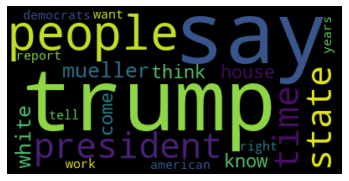

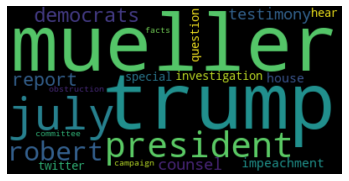

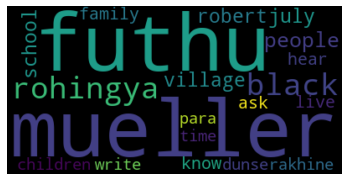

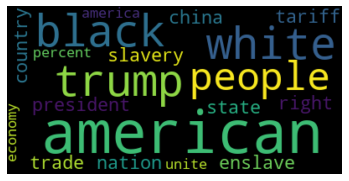

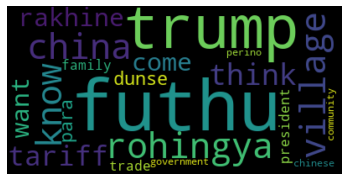

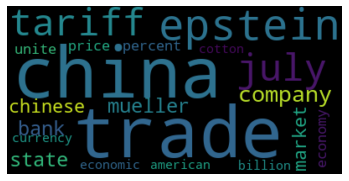

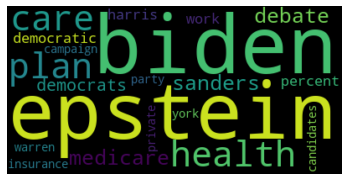

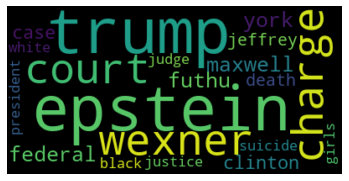

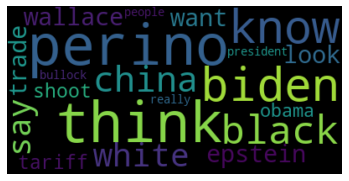

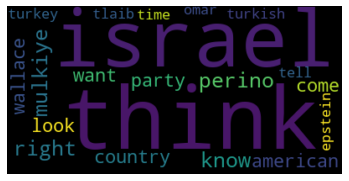

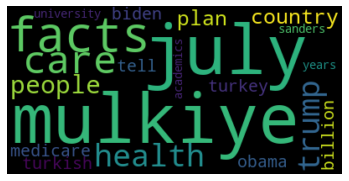

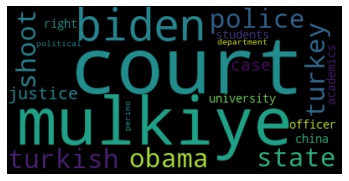

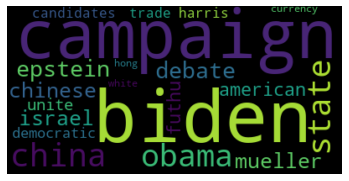

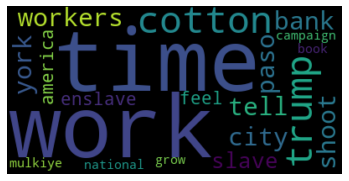

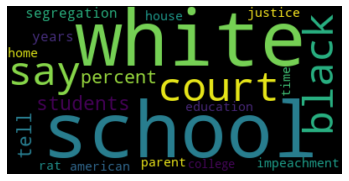

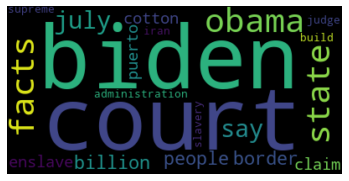

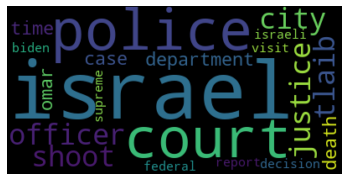

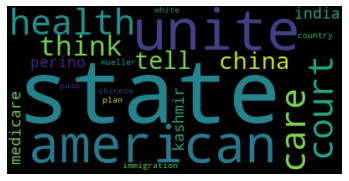

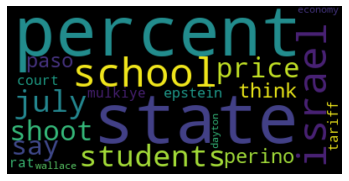

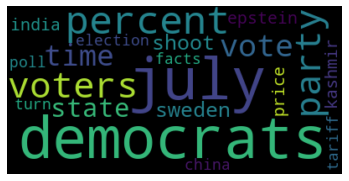

In [54]:
display_topic_wordcloud(lsa, count_vectorizer.get_feature_names(), 20)

In [55]:
 get_top_word_of_topics(lsa, count_vectorizer, n_components, 20)

Topic # 01     Topic # 02 Topic # 03 Topic # 04  Topic # 05 Topic # 06  \
0         say        mueller    mueller      black       futhu      china   
1       trump          trump      futhu      trump       trump      trade   
2      people           july   rohingya      white    rohingya    epstein   
3   president      president      black     people       china     tariff   
4       state         robert     people   american     village       july   
5        time      democrats    village  americans        know    company   
6     mueller         report       july  president       think    mueller   
7       white      testimony     school      china      tariff      state   
8       house        counsel     robert    enslave     rakhine       bank   
9        come    impeachment     family    slavery        come    chinese   
10       know          house       hear      state        want     market   
11      think  investigation        ask      right       dunse    percent   
12     report           hear       know    country        para      unite   
13  democrats        twitter       live      trade      family    economy   
14      years        special   children     nation   president      price   
15       tell       question    rakhine     tariff       trade   currency   
16   american      committee      write    percent  government   american   
17       work    obstruction      dunse    america      perino    billion   
18      right       campaign       para    economy     chinese   economic   
19       want          facts       time      unite   community     cotton   

    Topic # 07 Topic # 08 Topic # 09 Topic # 10  Topic # 11  Topic # 12  \
0        biden    epstein      think      think        july       court   
1      epstein      trump     perino     israel     mulkiye     mulkiye   
2       health     wexner      biden     perino       facts       biden   
3         care     charge       know      right        care      police   
4         plan      court      black    mulkiye      health       state   
5     medicare    federal      china       know       trump      turkey   
6       debate       york      white    country      people       obama   
7      sanders    maxwell        say    wallace     country     turkish   
8    democrats      futhu    epstein   american        plan       shoot   
9   democratic    clinton       look       look    medicare     justice   
10        work       case    wallace       want        tell        case   
11     percent    jeffrey       want       come      turkey  university   
12      harris      death      trade      party       obama       right   
13   insurance    justice     tariff     turkey       biden    students   
14      warren  president      shoot       time     turkish     officer   
15    campaign      white      obama    turkish     billion   academics   
16       party    suicide  president    epstein  university       china   
17  candidates      black     really      tlaib       years   political   
18        york      judge    bullock       tell     sanders      perino   
19     private      girls     people       omar   academics  department   

    Topic # 13 Topic # 14   Topic # 15      Topic # 16  Topic # 17  \
0        biden       time       school           biden      israel   
1     campaign       work        white           court      police   
2        china     cotton          say           obama       court   
3        state      trump        court           facts     officer   
4        obama    workers        black           state     justice   
5      epstein       tell     students            july        city   
6       debate       york         tell             say       shoot   
7      chinese       city      percent          people       tlaib   
8       israel       bank  segregation          border  department   
9      mueller       paso        years         billion        case   
10    american      shoot  impeachment 

**TfidfVectorizer**

In [56]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
n_components = 20
lsa = TruncatedSVD(n_components)
doc_topic_tfidf  = lsa.fit_transform(doc_word_tfidf) #doc_word_tfidf_norm
lsa.explained_variance_ratio_

array([0.00068164, 0.00334029, 0.00211249, 0.00206901, 0.00178822,
       0.0017173 , 0.00161648, 0.00160054, 0.0015328 , 0.00138555,
       0.00135921, 0.00134805, 0.00132317, 0.00130392, 0.00129637,
       0.00128223, 0.00128164, 0.00126137, 0.0012429 , 0.00120692])

In [57]:
topic_word_tfidf = pd.DataFrame(lsa.components_.round(3),
             index = ['component_' + str(i) for i in range(n_components)],
             columns = tfidf_vectorizer.get_feature_names())
topic_word_tfidf

aabramson  aabramson july   aapl  aapl netflix  aapl sales  \
component_0         0.0             0.0  0.001         0.000       0.000   
component_1        -0.0            -0.0 -0.000        -0.000      -0.000   
component_2        -0.0            -0.0  0.001         0.000       0.000   
component_3        -0.0            -0.0  0.003         0.001       0.001   
component_4         0.0             0.0  0.001         0.000       0.000   
component_5        -0.0            -0.0  0.000        -0.000       0.000   
component_6         0.0             0.0  0.001         0.000       0.001   
component_7        -0.0            -0.0  0.001         0.000       0.000   
component_8        -0.0            -0.0 -0.000        -0.000       0.000   
component_9        -0.0            -0.0 -0.000        -0.000      -0.000   
component_10       -0.0            -0.0 -0.000        -0.000      -0.000   
component_11       -0.0            -0.0  0.000        -0.000       0.000   
component_12        0.0             0.0  0.000         0.000      -0.000   
component_13        0.0             0.0  0.000         0.000       0.000   
component_14        0.0             0.0  0.000        -0.000       0.000   
component_15       -0.0            -0.0 -0.000         0.000       0.000   
component_16       -0.0            -0.0 -0.000        -0.000      -0.000   
component_17        0.0             0.0  0.000        -0.000       0.000   
component_18       -0.0            -0.0 -0.000        -0.000      -0.000   
component_19       -0.0            -0.0  0.000         0.000       0.000   

              aapl surge  aapl transsion  aare  aare cool  aarhus  ...  \
component_0        0.000             0.0   0.0        0.0     0.0  ...   
component_1       -0.000             0.0  -0.0       -0.0    -0.0  ...   
component_2        0.000             0.0   0.0        0.0     0.0  ...   
component_3        0.001             0.0   0.0        0.0     0.0  ...   
component_4        0.000             0.0  -0.0       -0.0    -0.0  ...   
component_5        0.000             0.0   0.0        0.0     0.0  ...   
component_6        0.001             0.0  -0.0       -0.0    -0.0  ...   
component_7        0.000             0.0  -0.0       -0.0    -0.0  ...   
component_8        0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_9       -0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_10       0.000             0.0   0.0        0.0     0.0  ...   
component_11       0.000             0.0  -0.0       -0.0    -0.0  ...   
component_12       0.000            -0.0   0.0        0.0     0.0  ...   
component_13       0.000             0.0  -0.0       -0.0    -0.0  ...   
component_14      -0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_15      -0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_16      -0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_17       0.000             0.0   0.0        0.0     0.0  ...   
component_18      -0.000            -0.0  -0.0       -0.0    -0.0  ...   
component_19       0.000             0.0  -0.0       -0.0    -0.0  ...   

              zwart say  zwilling  zwilling spokesman  zwirner  zwirner build  \
component_0       0.000     0.001               0.001    0.000          0.000   
component_1      -0.000    -0.000              -0.000   -0.000         -0.000   
component_2       0.000     0.001               0.001    0.000          0.000   
component_3      -0.000    -0.000              -0.000    0.000          0.000   
component_4      -0.000    -0.000              -0.000   -0.000         -0.000   
component_5       0.001    -0.000              -0.000   -0.000         -0.000   
component_6      -0.000    -0.001              -0.001   -0.001         -0.001   
component_7       0.000    -0.000              -0.000   -0.000         -0.000   
component_8       0.000     0.000               0.000   -0.000         -0.000   
component_9       0.000    -0.001              -0.00

In [58]:
display_topics(lsa, tfidf_vectorizer.get_feature_names(), 15)


Topic  0
say, president, trump, people, know, time, state, report, support, come, issue, news, tell, include, house

Topic  1
report break, page want, break link, lose page, lose report, want lose, sorry lose, sorry, link, page, break, lose, want, report, facebook page

Topic  2
epstein, jeffrey epstein, jeffrey, traffic, girls, manhattan, jail, charge, correctional, prosecutors, guilty, plead guilty, correctional center, prison, arrest

Topic  3
trade, market, economy, growth, china, economic, federal reserve, rate, reserve, stock, tariff, investment, increase, slow, investors

Topic  4
mueller, robert mueller, special counsel, counsel, impeachment, testimony, committee, tlaib, judiciary, omar, rashida, rashida tlaib, ilhan, ilhan omar, robert

Topic  5
omar, ilhan, ilhan omar, tlaib, rashida tlaib, israel, rashida, israeli, minister, boycott, hate, jewish, omar tlaib, muslim, prime minister

Topic  6
comment, paso, breitbart, issue comment, comment breitbart, know issue, dayton, ohi

In [59]:
Vt_tfidf = pd.DataFrame(doc_topic_tfidf .round(5),
             index = df['title'],
             columns =  ['component_' + str(i) for i in range(n_components)],)
Vt_tfidf 

component_0  component_1  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.06184      0.01057   
20 beautiful European cities with hardly any to...      0.07164     -0.00034   
Ryan campaign blames 'absentmindedness' for not...      0.07705     -0.00348   
Violence escalates in Zimbabwe as court rules a...      0.08927     -0.00175   
Blindfolding US teen accused of killing officer...      0.08099     -0.00233   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.06848     -0.00085   
Kamala Harris: President Needs 'Courage' to Emb...      0.09382     -0.00234   
Al Green Vows to Force Impeachment Vote This Month      0.11156     -0.00241   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      0.09159      0.00007   
Nolte: Left-wing Netflix Lost 130,000 American ...      0.07545      0.00741   

                                                    component_2  component_3  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.00457     -0.00053   
20 beautiful European cities with hardly any to...      0.02133      0.01920   
Ryan campaign blames 'absentmindedness' for not...     -0.03356     -0.00435   
Violence escalates in Zimbabwe as court rules a...      0.01945      0.00043   
Blindfolding US teen accused of killing officer...      0.03638     -0.02333   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...     -0.03485     -0.02723   
Kamala Harris: President Needs 'Courage' to Emb...     -0.01352     -0.04235   
Al Green Vows to Force Impeachment Vote This Month     -0.08956     -0.05019   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...     -0.05710     -0.03484   
Nolte: Left-wing Netflix Lost 130,000 American ...     -0.00425     -0.00044   

                                                    component_4  component_5  \
title                                                                          
A pastor who wrote a bestselling relationship b...     -0.01547      0.00889   
20 beautiful European cities with hardly any to...     -0.02047      0.01505   
Ryan campaign blames 'absentmindedness' for not...     -0.02489     -0.02072   
Violence escalates in Zimbabwe as court rules a...     -0.00622      0.02697   
Blindfolding US teen accused of killing officer...     -0.01073      0.02141   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.00520     -0.00087   
Kamala Harris: President Needs 'Courage' to Emb...     -0.05542      0.00244   
Al Green Vows to Force Impeachment Vote This Month      0.07037      0.04519   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      0.03169      0.03747   
Nolte: Left-wing Netflix Lost 130,000 American ...     -0.00865     -0.00132   

                                                    component_6  component_7  \
title                                                                          
A pastor who wrote a bestselling relationship b...     -0.02410     -0.00196   
20 beautiful European cities with hardly any to...     -0.03131     -0.00763   
Ryan campaign blames 'absentmindedness' for not...      0.00125      0.00470   
Violence escalates in Zimbabwe as court rules a...     -0.00779      0.00476   
Blindfolding US teen accused of killing officer...      0.00091      0.00113   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.02614      0.00961   
Kamala Harris: President Needs 'Courage' to Emb...      0.08003      0.04725   
Al Green Vows to Force Impeachment Vote This Month      0.01941      0.02131   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i..

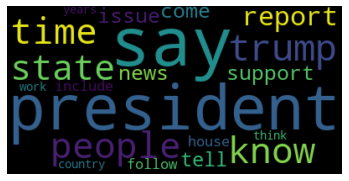

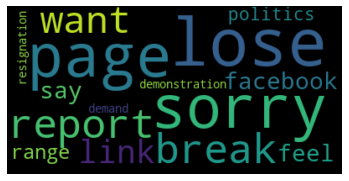

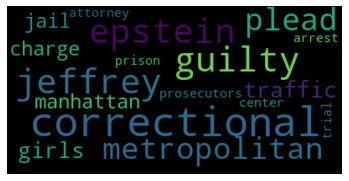

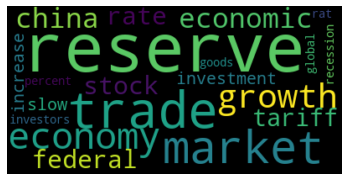

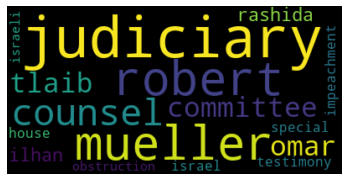

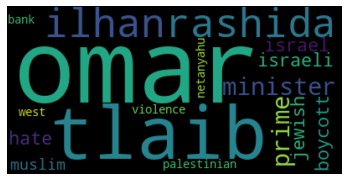

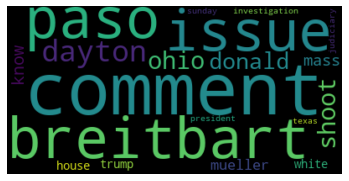

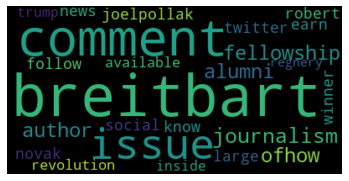

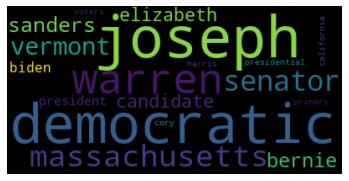

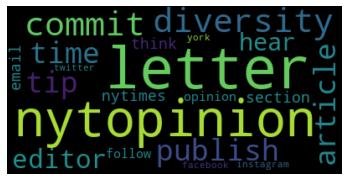

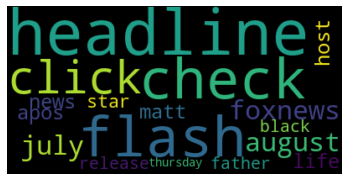

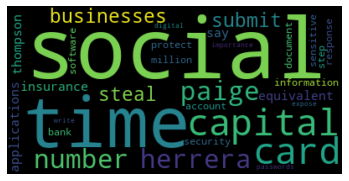

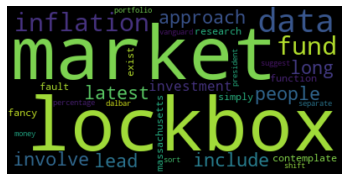

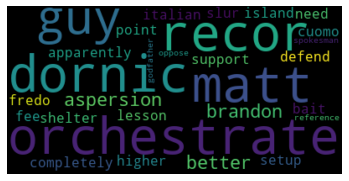

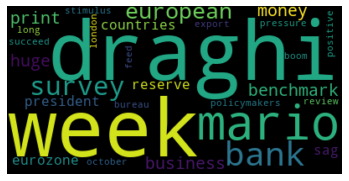

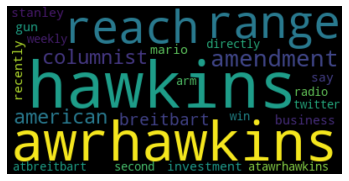

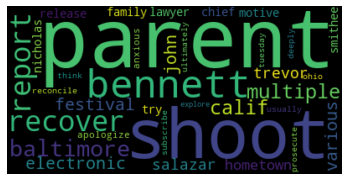

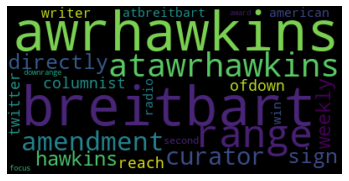

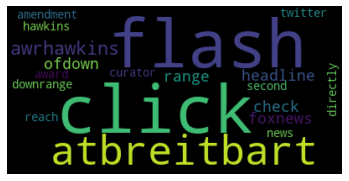

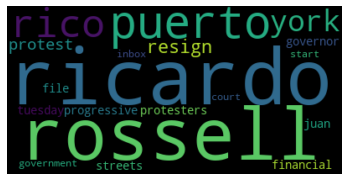

In [60]:
display_topic_wordcloud(lsa, tfidf_vectorizer.get_feature_names(), 20)

In [61]:
 get_top_word_of_topics(lsa, tfidf_vectorizer, n_components, 20)

Topic # 01          Topic # 02                 Topic # 03       Topic # 04  \
0         say        report break                    epstein            trade   
1   president           page want            jeffrey epstein           market   
2       trump          break link                    jeffrey          economy   
3      people           lose page                    traffic           growth   
4        know         lose report                      girls            china   
5        time           want lose                  manhattan         economic   
6       state          sorry lose                       jail  federal reserve   
7      report               sorry                     charge             rate   
8     support                link               correctional          reserve   
9        come                page                prosecutors            stock   
10      issue               break                     guilty           tariff   
11       news                lose               plead guilty       investment   
12       tell                want        correctional center         increase   
13    include              report                     prison             slow   
14      house       facebook page                     arrest        investors   
15     follow          sorry feel                   attorney          percent   
16    country           say sorry                      plead              rat   
17      think      range politics               metropolitan        recession   
18       work       demonstration  metropolitan correctional           global   
19      years  demand resignation                      trial            goods   

             Topic # 05      Topic # 06         Topic # 07  \
0               mueller            omar            comment   
1        robert mueller           ilhan               paso   
2       special counsel      ilhan omar          breitbart   
3               counsel           tlaib      issue comment   
4           impeachment   rashida tlaib  comment breitbart   
5             testimony          israel         know issue   
6             committee         rashida             dayton   
7                 tlaib         israeli               ohio   
8             judiciary        minister         mass shoot   
9                  omar         boycott        dayton ohio   
10              rashida            hate            mueller   
11        rashida tlaib          jewish              trump   
12                ilhan      omar tlaib        white house   
13           ilhan omar          muslim      investigation   
14               robert  prime minister         paso texas   
15      house judiciary     palestinian             sunday   
16               israel       netanyahu              shoot   
17          obstruction        violence             donald   
18  judiciary committee           prime          judiciary   
19              israeli       west bank   president donald   

              Topic # 08               Topic # 09            Topic # 10  \
0          issue comment             joseph biden      diversity letter   
1      comment breitbart     warren massachusetts        commit publish   
2             know issue         president joseph           article tip   
3              breitbart               candidates           time commit   
4                comment                  senator           editor hear   
5         breitbart news                  vermont        letter nytimes   
6         follow twitter            massachusetts         think article   
7       novak journalism          sanders vermont             tip email   
8             joelpollak               democratic     publish diversity   
9        large breitbart  democratic presidential         letter editor   
10         winner robert        harris california          email letter   
11           earn social                   joseph            hear think   
12     fellowship autho

##  Non-Negative Matrix Factorization (NMF)

We are going to start with documents that contain many unique words (or features). The goal is to reduce those words down into 10 topics, so that each document can be represented as some combination of the 10 topics. We will be using NMF this time around.

$X_{n \times m} = W_{n \times k} * H_{k \times m}$

k is number of components

In [64]:
n_components = 20
nmf_model = NMF(n_components)
doc_topic = nmf_model.fit_transform(doc_word)

In [65]:
nmf_model

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

The ***W matrix*** shows us the 10 resulting topics, and the terms that are associated with each topic. In this case:

- Topic  0 seems to be about trade war


- Topic  1 seems to be about China 


- Topic  2 seems to be about gun 


- Topic  3 seems to be about Trump impeachment


- Topic  4 seems to be about Epstein and sex


- Topic  5 seems to be about healthcare and democrate


- Topic  6 seems to be about politics


- Topic  7 seems to be about president


- Topic  8 seems to be about middle east


- Topic  9 seems to be about  music

In [66]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ['component_' + str(i) for i in range(n_components)],
             columns = count_vectorizer.get_feature_names())
topic_word

aabramson   aapl   aare  aarhus  aaron  aaronblake  \
component_0       0.000  0.000  0.000   0.000  0.001       0.000   
component_1       0.039  0.000  0.000   0.000  0.153       0.042   
component_2       0.000  0.000  0.000   0.000  0.004       0.000   
component_3       0.000  0.000  0.000   0.000  0.006       0.000   
component_4       0.000  0.000  0.000   0.000  0.000       0.000   
component_5       0.000  0.008  0.000   0.000  0.000       0.000   
component_6       0.000  0.000  0.000   0.000  0.000       0.000   
component_7       0.000  0.000  0.000   0.000  0.018       0.000   
component_8       0.000  0.000  0.000   0.000  0.000       0.000   
component_9       0.000  0.000  0.000   0.001  0.062       0.000   
component_10      0.000  0.000  0.000   0.000  0.083       0.000   
component_11      0.000  0.000  0.000   0.000  0.179       0.000   
component_12      0.000  0.000  0.000   0.000  0.000       0.000   
component_13      0.000  0.000  0.002   0.006  0.005       0.000   
component_14      0.000  0.000  0.000   0.000  0.000       0.000   
component_15      0.000  0.000  0.000   0.001  0.000       0.000   
component_16      0.000  0.000  0.002   0.006  0.002       0.000   
component_17      0.000  0.006  0.000   0.000  0.000       0.000   
component_18      0.000  0.000  0.000   0.000  0.000       0.000   
component_19      0.000  0.000  0.000   0.000  0.000       0.000   

              aaronkleinshow   aarp  aback  abalone  ...  zumaya  zunig  \
component_0            0.000  0.003  0.034    0.002  ...   0.000  0.001   
component_1            0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_2            0.000  0.000  0.018    0.000  ...   0.000  0.000   
component_3            0.000  0.000  0.034    0.000  ...   0.000  0.000   
component_4            0.000  0.000  0.000    0.000  ...   0.017  0.000   
component_5            0.000  0.000  0.000    0.002  ...   0.000  0.000   
component_6            0.000  0.024  0.000    0.000  ...   0.000  0.000   
component_7            0.010  0.000  0.000    0.000  ...   0.000  0.000   
component_8            0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_9            0.000  0.000  0.039    0.000  ...   0.000  0.000   
component_10           0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_11           0.004  0.000  0.006    0.000  ...   0.000  0.001   
component_12           0.001  0.017  0.000    0.000  ...   0.002  0.000   
component_13           0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_14           0.000  0.000  0.000    0.000  ...   0.050  0.000   
component_15           0.000  0.000  0.025    0.000  ...   0.000  0.000   
component_16           0.004  0.000  0.000    0.000  ...   0.000  0.001   
component_17           0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_18           0.000  0.000  0.000    0.000  ...   0.000  0.000   
component_19           0.000  0.000  0.000    0.000  ...   0.000  0.000   

              zurich  zutjektzs  zuzana  zwart  zwilling  zwirner  zxcyl  \
component_0    0.019      0.000   0.002  0.016     0.016    0.011  0.000   
component_1    0.000      0.000   0.000  0.000     0.000    0.000  0.000   
component_2    0.001      0.000   0.000  0.000     0.000    0.000  0.000   
component_3    0.000      0.000   0.000  0.000     0.000    0.000  0.000   
component_4    0.000      0.000   0.000  0.000     0.000    0.000  0.000   
component_5    0.000      0.000   0.000  0.000     0.000    0.000  0.000   
component_6    0.000      0.000   0.000  0.000     0.000    0.000  0.000   
component_7    0.000      0.000   0.000  0.000     0.001    0.000  0.000   
component_8    0.000      0.000   0.000  0.000     0.011    0.000  0.000   
component_9    0.004      0.000   0.000  0.000     0.000    0.000  0.000   
component_10   0.000      0.001   0.000  0.000     0.000    0.000  0.001   
component_11   0.012      0.000   0.002  0.001     0.000    0.000  0.000   
component_12   0.000 

In [67]:
display_topics(nmf_model, count_vectorizer.get_feature_names(), 10)


Topic  0
say, work, time, tell, come, know, family, home, years, city

Topic  1
mueller, july, robert, trump, president, report, hear, say, twitter, testimony

Topic  2
futhu, rohingya, village, school, people, family, know, come, time, rakhine

Topic  3
black, white, people, americans, american, right, country, slavery, nation, enslave

Topic  4
trump, president, white, racist, campaign, report, tweet, attack, political, democratic

Topic  5
china, chinese, trade, state, unite, say, american, tariff, currency, trump

Topic  6
health, care, plan, medicare, sanders, insurance, cost, people, private, warren

Topic  7
epstein, wexner, york, charge, maxwell, time, federal, jeffrey, suicide, clinton

Topic  8
state, court, case, justice, federal, supreme, rule, administration, judge, government

Topic  9
think, perino, know, president, want, wallace, look, right, people, time

Topic  10
trump, facts, july, say, people, billion, years, china, tariff, obama

Topic  11
israel, tlaib, omar, is

The ***H matrix*** shows us the documents we started with, and how each document is made up of the 10 resulting topics. In this case:

- The first document seems to be about music

- The last document seems to be about China trade war and Trump

- Everything in between is a combination of 

In [68]:
H = pd.DataFrame(doc_topic.round(5),
             index = df.title,
             columns = ['component_' + str(i) for i in range(n_components)])
H

component_0  component_1  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.03259      0.00000   
20 beautiful European cities with hardly any to...      0.12596      0.00000   
Ryan campaign blames 'absentmindedness' for not...      0.07719      0.00000   
Violence escalates in Zimbabwe as court rules a...      0.30678      0.00000   
Blindfolding US teen accused of killing officer...      0.49940      0.00559   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.08263      0.00684   
Kamala Harris: President Needs 'Courage' to Emb...      0.00000      0.03611   
Al Green Vows to Force Impeachment Vote This Month      0.39988      0.00000   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      0.05317      0.00731   
Nolte: Left-wing Netflix Lost 130,000 American ...      0.00172      0.00000   

                                                    component_2  component_3  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.06774      0.03598   
20 beautiful European cities with hardly any to...      0.06305      0.00000   
Ryan campaign blames 'absentmindedness' for not...      0.00000      0.00472   
Violence escalates in Zimbabwe as court rules a...      0.01881      0.07855   
Blindfolding US teen accused of killing officer...      0.00000      0.00000   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.00000      0.07417   
Kamala Harris: President Needs 'Courage' to Emb...      0.00000      0.00000   
Al Green Vows to Force Impeachment Vote This Month      0.00000      0.01256   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      0.02047      0.00229   
Nolte: Left-wing Netflix Lost 130,000 American ...      0.04012      0.05575   

                                                    component_4  component_5  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.00000      0.00000   
20 beautiful European cities with hardly any to...      0.00000      0.00000   
Ryan campaign blames 'absentmindedness' for not...      0.07044      0.00000   
Violence escalates in Zimbabwe as court rules a...      0.01564      0.06437   
Blindfolding US teen accused of killing officer...      0.00000      0.00522   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.11325      0.00000   
Kamala Harris: President Needs 'Courage' to Emb...      0.01357      0.00000   
Al Green Vows to Force Impeachment Vote This Month      0.49671      0.06035   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i...      0.29114      0.00000   
Nolte: Left-wing Netflix Lost 130,000 American ...      0.02709      0.00000   

                                                    component_6  component_7  \
title                                                                          
A pastor who wrote a bestselling relationship b...      0.03358      0.02954   
20 beautiful European cities with hardly any to...      0.00046      0.00000   
Ryan campaign blames 'absentmindedness' for not...      0.06648      0.00000   
Violence escalates in Zimbabwe as court rules a...      0.08920      0.00000   
Blindfolding US teen accused of killing officer...      0.00000      0.00000   
...                                                         ...          ...   
FNC's Chris Wallace: Trump's Cummings Attack Is...      0.00000      0.00000   
Kamala Harris: President Needs 'Courage' to Emb...      0.01325      0.02309   
Al Green Vows to Force Impeachment Vote This Month      0.00000      0.00000   
CNN, MSNBC Say ‘Racist’ More Than 1,100 Times i..

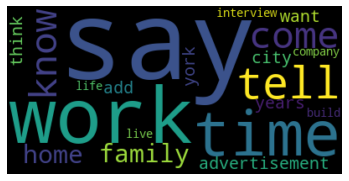

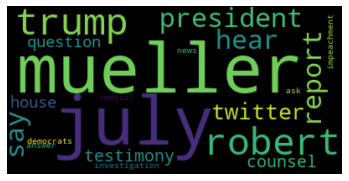

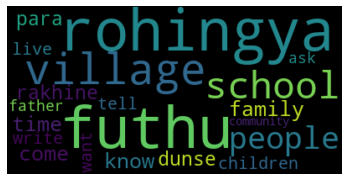

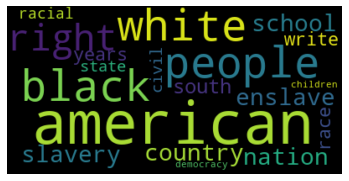

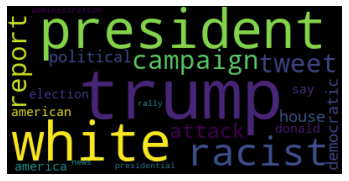

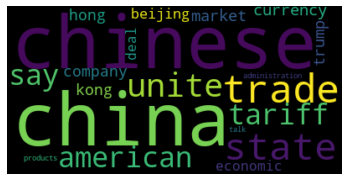

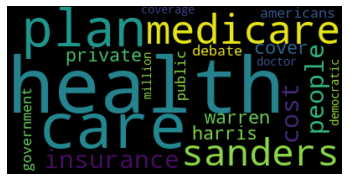

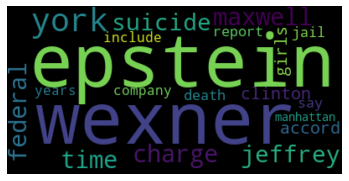

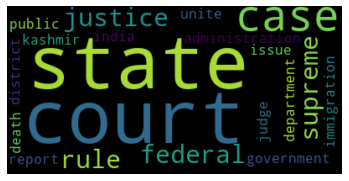

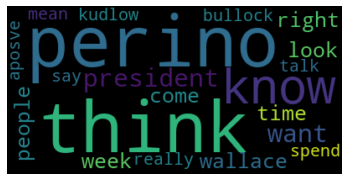

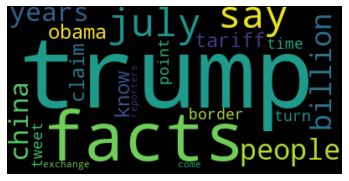

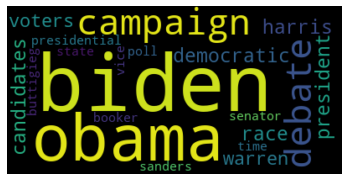

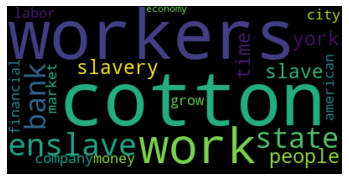

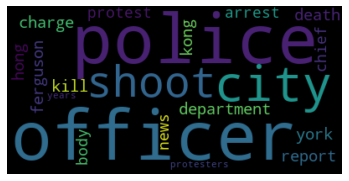

In [298]:
#display_topic_wordcloud(nmf_model, count_vectorizer.get_feature_names(), 20)
display_topic_wordcloud(nmf_model, count_vectorizer.get_feature_names(), 20)

In [70]:
 get_top_word_of_topics(nmf_model, count_vectorizer, n_components, 20)

Topic # 01     Topic # 02 Topic # 03 Topic # 04      Topic # 05  \
0             say        mueller      futhu      black           trump   
1            work           july   rohingya      white       president   
2            time         robert    village     people           white   
3            tell          trump     school  americans          racist   
4            come      president     people   american        campaign   
5            know         report     family      right          report   
6          family           hear       know    country           tweet   
7            home            say       come    slavery          attack   
8           years        twitter       time     nation       political   
9            city      testimony    rakhine    enslave      democratic   
10            add        counsel       para     school           house   
11  advertisement       question      dunse      south        american   
12           want          house   children      years          donald   
13          think  investigation       live       race        election   
14           york        special       tell      write         america   
15        company      democrats      write      state             say   
16          build            ask       want      civil    presidential   
17      interview         answer     father     racial            news   
18           life           news        ask  democracy  administration   
19           live    impeachment  community   children           rally   

        Topic # 06  Topic # 07 Topic # 08      Topic # 09 Topic # 10  \
0            china      health    epstein           state      think   
1          chinese        care     wexner           court     perino   
2            trade        plan       york            case       know   
3            state    medicare     charge         justice  president   
4            unite     sanders    maxwell         federal       want   
5              say   insurance       time         supreme    wallace   
6         american        cost    federal            rule       look   
7           tariff      people    jeffrey  administration      right   
8         currency     private    suicide           judge     people   
9            trump      warren    clinton      government       time   
10          market      harris     accord           unite       come   
11         company       cover      girls      department       week   
12            hong   americans     report           death     really   
13            kong      debate       jail          public    bullock   
14         beijing  government        say           india       mean   
15        economic      public      death         kashmir     kudlow   
16            deal    coverage    company     immigration      spend   
17  administration     million    include        district     aposve   
18        products      doctor      years          report        say   
19            talk  democratic  manhattan           issue       talk   

   Topic # 11     Topic # 12    Topic # 13 Topic # 14  Topic # 15  Topic # 16  \
0       trump         israel         biden     cotton       shoot     mulkiye   
1       facts          tlaib         obama    workers      people      turkey   
2        july           omar      campaign       work        paso     turkish   
3         say        israeli        debate    enslave         say       right   
4      people          visit    democratic      state        mass  university   
5     billion        boycott        harris       bank      dayton    students   
6       years      netanyahu    candidates     people        kill     country   
7       china       decision     president    slavery    violence   academics   
8      tariff       american          race      slave       white       state   
9       obama        support        voters       york       state   political   
10       know           anti        warren      

## Latent Dirichlet Allocation (LDA) with gensim


Latent Dirichlet Allocation (LDA) is used to classify text in a document to a particular topic.

It builds :

- a topic per document model 

- words per topic model, (modeled as Dirichlet distributions)

### Running LDA using Bag of Words

In [72]:
dataset = [d.split() for d in df['refined_article']]

dictionary = corpora.Dictionary(dataset)

corpus = [dictionary.doc2bow(text) for text in dataset]


# list of number of topics 
topicnums = [1,5,10,15,20,30,40,50]

# list of lda models using tfidf features
ldamodels = {}

for i in topicnums:
    random.seed(42)
    %time ldamodels[i] = models.LdaModel(corpus, num_topics=i, id2word=dictionary)
    #%time ldamodels[i] = models.LdaMulticore(corpus, num_topics=i, id2word=dictionary, passes=2, workers=2)
    ldamodels[i].save('./model/ldamodels_'+str(i)+'.lda')

CPU times: user 1.76 s, sys: 4.43 ms, total: 1.77 s
Wall time: 1.77 s


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 19.2 s, sys: 74.2 ms, total: 19.3 s
Wall time: 4.87 s
CPU times: user 20.8 s, sys: 100 ms, total: 20.9 s
Wall time: 5.26 s
CPU times: user 22.1 s, sys: 126 ms, total: 22.2 s
Wall time: 5.6 s
CPU times: user 23.3 s, sys: 173 ms, total: 23.5 s
Wall time: 5.97 s
CPU times: user 22.7 s, sys: 101 ms, total: 22.8 s
Wall time: 5.74 s
CPU times: user 27.8 s, sys: 207 ms, total: 28 s
Wall time: 7.17 s
CPU times: user 33.7 s, sys: 288 ms, total: 34 s
Wall time: 8.66 s


In [73]:
for i in topicnums:
    lda_model = models.LdaModel.load('./model/ldamodels_'+str(i)+'.lda')
    #print(lda_model.print_topics(), '\n\n')
    
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))
    
    # Transform the docs from the word space to the topic space (like "transform" in sklearn)
    lda_model_corpus = lda_model[corpus]



    # Store the documents' topic vectors in a list so we can take a peak
    lda_docs = [doc for doc in lda_model_corpus]
    
    
    # Check out the document vectors in the topic space for the first 5 documents
    print(lda_docs[0:5], '\n\n')

Topic: 0 
Words: 0.014*"say" + 0.008*"trump" + 0.005*"people" + 0.005*"president" + 0.005*"state" + 0.005*"time" + 0.003*"know" + 0.003*"report" + 0.003*"white" + 0.003*"house"
[[(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 1.0)]] 


Topic: 0 
Words: 0.015*"say" + 0.007*"trump" + 0.006*"state" + 0.005*"people" + 0.004*"time" + 0.004*"epstein" + 0.004*"know" + 0.003*"president" + 0.003*"house" + 0.003*"support"
Topic: 1 
Words: 0.010*"say" + 0.006*"state" + 0.005*"people" + 0.005*"trump" + 0.005*"percent" + 0.004*"president" + 0.004*"china" + 0.004*"time" + 0.004*"plan" + 0.003*"american"
Topic: 2 
Words: 0.017*"say" + 0.005*"time" + 0.005*"people" + 0.004*"state" + 0.004*"president" + 0.004*"trump" + 0.003*"house" + 0.003*"call" + 0.003*"report" + 0.003*"know"
Topic: 3 
Words: 0.016*"say" + 0.012*"trump" + 0.008*"people" + 0.007*"president" + 0.006*"time" + 0.006*"white" + 0.004*"shoot" + 0.004*"state" + 0.004*"know" + 0.004*"come"
Topic: 4 
Words: 0.015*"say" + 0.011*"trump" + 

[[(6, 0.17548974), (8, 0.36787522), (9, 0.4516932)], [(0, 0.025488557), (2, 0.11835971), (9, 0.13310145), (13, 0.010566016), (14, 0.48220885), (16, 0.0154387085), (17, 0.17061032), (18, 0.037353452)], [(0, 0.07673041), (2, 0.15148024), (4, 0.4730147), (7, 0.086488836), (9, 0.20692867)], [(5, 0.18803877), (8, 0.035962548), (9, 0.15517867), (10, 0.12012515), (15, 0.10410524), (16, 0.07034295), (19, 0.31670877)], [(4, 0.5027269), (8, 0.02861068), (9, 0.041392516), (13, 0.010938867), (18, 0.41478145)]] 


Topic: 0 
Words: 0.017*"say" + 0.007*"house" + 0.006*"impeachment" + 0.006*"people" + 0.005*"state" + 0.005*"democrats" + 0.005*"trump" + 0.005*"support" + 0.005*"shoot" + 0.004*"president"
Topic: 1 
Words: 0.015*"israel" + 0.013*"say" + 0.007*"tlaib" + 0.006*"trump" + 0.005*"omar" + 0.004*"time" + 0.004*"president" + 0.004*"visit" + 0.004*"people" + 0.003*"israeli"
Topic: 2 
Words: 0.011*"say" + 0.006*"time" + 0.006*"people" + 0.004*"work" + 0.004*"school" + 0.003*"go" + 0.003*"years" + 

[[(7, 0.114665374), (14, 0.05154145), (24, 0.098325364), (28, 0.3000732), (35, 0.43030736)], [(0, 0.013689878), (5, 0.37941983), (6, 0.03345137), (10, 0.057332695), (11, 0.02091378), (13, 0.044733364), (14, 0.02217322), (18, 0.07378516), (20, 0.017768947), (28, 0.052812226), (29, 0.028699813), (31, 0.02513236), (32, 0.023837522), (36, 0.07871445), (39, 0.10589054)], [(6, 0.07827473), (8, 0.12167219), (9, 0.088750966), (23, 0.042655345), (26, 0.07796836), (27, 0.4913863), (29, 0.09339927)], [(2, 0.03635722), (6, 0.41822463), (11, 0.030171335), (15, 0.33546692), (20, 0.014719666), (27, 0.051989906), (32, 0.095237136)], [(10, 0.016869863), (11, 0.8021304), (14, 0.040386934), (15, 0.016535344), (27, 0.048963446), (31, 0.016225154), (38, 0.04321505)]] 


Topic: 0 
Words: 0.014*"say" + 0.005*"york" + 0.005*"time" + 0.005*"mueller" + 0.005*"people" + 0.004*"trump" + 0.004*"state" + 0.004*"public" + 0.004*"abuse" + 0.004*"report"
Topic: 1 
Words: 0.008*"say" + 0.007*"book" + 0.005*"rat" + 0.00

[[(10, 0.98192585), (25, 0.012492764)], [(9, 0.054896697), (10, 0.06789861), (16, 0.026270123), (20, 0.07909819), (25, 0.012153734), (33, 0.034207728), (37, 0.13339378), (38, 0.06707895), (39, 0.13723421), (40, 0.07443017), (43, 0.18915005), (48, 0.03624867), (49, 0.055881675)], [(5, 0.20236745), (10, 0.1688747), (25, 0.43273616), (26, 0.028045194), (31, 0.057374656), (37, 0.02713155), (41, 0.07732746)], [(9, 0.63796395), (10, 0.013242346), (16, 0.021264158), (29, 0.042831853), (35, 0.12631185), (38, 0.05386291), (43, 0.05541225), (44, 0.020510439), (48, 0.026647868)], [(9, 0.062089436), (10, 0.47019947), (16, 0.09247663), (43, 0.034436602), (49, 0.30295098)]] 




In [74]:
!ls model

ldamodels_1.lda                        ldamodels_tfidf_1.lda
ldamodels_1.lda.expElogbeta.npy        ldamodels_tfidf_1.lda.expElogbeta.npy
ldamodels_1.lda.id2word                ldamodels_tfidf_1.lda.id2word
ldamodels_1.lda.state                  ldamodels_tfidf_1.lda.state
ldamodels_10.lda                       ldamodels_tfidf_10.lda
ldamodels_10.lda.expElogbeta.npy       ldamodels_tfidf_10.lda.expElogbeta.npy
ldamodels_10.lda.id2word               ldamodels_tfidf_10.lda.id2word
ldamodels_10.lda.state                 ldamodels_tfidf_10.lda.state
ldamodels_15.lda                       ldamodels_tfidf_15.lda
ldamodels_15.lda.expElogbeta.npy       ldamodels_tfidf_15.lda.expElogbeta.npy
ldamodels_15.lda.id2word               ldamodels_tfidf_15.lda.id2word
ldamodels_15.lda.state                 ldamodels_tfidf_15.lda.state
ldamodels_20.lda                       ldamodels_tfidf_20.lda
ldamodels_20.lda.expElogbeta.npy       ldamodels_tfidf_20.lda.expElogbeta.npy
ldamodels_20.lda.id2word      

#### Performance evaluation by classifying sample document using LDA Bag of Words model

In [76]:
df['refined_article'][100]

'washington things theme song week theme paint poll week marist college poll find democrats believe good idea health care private insurers government option public option smaller democrats good idea medicare government health care plan pretty replace private insurance point health care issue democratic primary voters divide lead democratic presidential contenders issue sens kamala harris california bernie sanders vermont elizabeth warren massachusetts favor medicare vice president biden lone democrat favor public option popular option democrats particularly black democrats marist poll number poll suggest biden popular stance democrats general electorate ssrs poll conduct month thing poll ask national insurance plan say ask follow replace private insurance potential democrats democratic lean independents favor public option follow want medicare surprisingly didn want national health care plan biden try advantage poll number run fact health care proposal allow people private insurance wa

In [77]:
lda_model = models.LdaModel.load('./model/ldamodels_40.lda')

for index, score in sorted(lda_model[corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7673811912536621	 
Topic: 0.021*"health" + 0.014*"care" + 0.011*"insurance" + 0.011*"medicare" + 0.011*"plan" + 0.010*"say" + 0.008*"sanders" + 0.007*"trump" + 0.006*"president" + 0.005*"people"

Score: 0.16482800245285034	 
Topic: 0.026*"biden" + 0.009*"say" + 0.007*"trump" + 0.007*"white" + 0.007*"people" + 0.005*"democratic" + 0.005*"debate" + 0.005*"black" + 0.005*"president" + 0.005*"harris"

Score: 0.03508991375565529	 
Topic: 0.012*"trump" + 0.012*"say" + 0.006*"president" + 0.005*"state" + 0.005*"voters" + 0.005*"time" + 0.005*"white" + 0.005*"house" + 0.004*"people" + 0.004*"republican"

Score: 0.021561596542596817	 
Topic: 0.019*"say" + 0.017*"trump" + 0.008*"people" + 0.008*"president" + 0.008*"state" + 0.005*"white" + 0.004*"issue" + 0.004*"support" + 0.004*"know" + 0.003*"unite"


#### Testing model on unseen document

In [78]:
unseen_document = 'Donald Trump is doing a very poor job of not caring that his former friend Anthony \
Scaramucci has turned on him Just another disgruntled former employee who got fired for gross incompetence \
Trump tweeted Tuesday morning of his former White House communications director That Trump tweet came less \
than 12 hours after this one, again on the Mooch Nobody ever heard of this dope until he met me He only lasted \
11 days And earlier on Monday Trump sent this tweet Anthony Scaramucci is a highly unstable nut job who was \
with other candidates in the primary who got shellacked  then unfortunately wheedled his way into my campaign\
I barely knew him until his 11 days of gross incompetence made a fool of himself bad on TV Does that seem \
like someone who is totally unbothered by Scaramucci public rejection of him in a variety of interviews and \
tweets this month Remember always, that Trump Twitter feed is a direct line to his mental and emotional state \
Trump allies in the White House and outside of it  can say whatever they want, but what really matters is \
what Trump tweets If he tweets about it, he cares about it Bigly Which begs the question Why does Trump care \
so much about Scaramucci rebellion The answer is as always with Trump, tied directly to how he views the \
world There are only two kinds of people  the pro Trump ones and the anti Trump ones. People who have been \
pro Trump for a long time or at least before he was elected president he keeps closer and values more \
Those are his OG people the ones who have been with him from the jump It not a big group  and mostly \
family But there are a few non-family members in there and Scaramucci was one When those pro Trumpers turn on \
him Trump goes bananas We saw just that scenario play out with Michael Cohen Trump longtime attorney and \
personal fixer. In the immediate aftermath of Cohen arrest on charges of tax evasion and other financial\
crimes Trump stood up for him Trump praised Cohen in April 2018 fine person with a wonderful family and \
someone who he had always liked respected Then Cohen flipped  entering into a plea agreement to cooperate\
with special counsel Robert Mueller and the Southern District of New York on several investigations into \
Trump world Trump didn take that decision well if anyone is looking for a good lawyer I would strongly \
suggest that you don retain the services of Michael Cohen Trump tweeted in August 2018 Added Trump this\
past February Michael Cohen was one of many lawyers who represented me unfortunately He had other clients \
also He was just disbarred by the State Supreme Court for lying  fraud. He did bad things unrelated to Trump\
He is lying in order to reduce his prison time. Using Crooked lawyer And this one from March Bad lawyer and \
fraudster Michael Cohen said under sworn testimony that he never asked for a Pardon His lawyers totally \
contradicted him He lied Additionally he directly asked me for a pardon I said NO He lied again He also \
badly wanted to work at the White House He lied Hell hath no fury like Donald Trump scorned Trump feels \
deeply done wrong by the likes of Scaramucci and Cohen or even Omarosa Manigault Newman In his own mind he \
brought them into the trust tree made them who they are and now they have turned on him For someone who \
demands total loyalty forever from the people in his orbit but who interestingly doesn  feel the need to be \
loyal back Trump sees what Scaramucci is doing as the ultimate betrayal Hence his totally over the top reaction'


unseen_document = preprocess(unseen_document).split()
bow_vector = dictionary.doc2bow(unseen_document)

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)), '\n\n')

Score: 0.5793884992599487	 Topic: 0.019*"say" + 0.017*"trump" + 0.008*"people" + 0.008*"president" + 0.008*"state" + 0.005*"white" + 0.004*"issue" + 0.004*"support" + 0.004*"know" + 0.003*"unite" 


Score: 0.2874836325645447	 Topic: 0.018*"epstein" + 0.016*"say" + 0.009*"trump" + 0.006*"time" + 0.006*"president" + 0.005*"charge" + 0.005*"federal" + 0.005*"state" + 0.005*"know" + 0.004*"people" 


Score: 0.09673985838890076	 Topic: 0.032*"mueller" + 0.020*"say" + 0.011*"trump" + 0.008*"report" + 0.007*"president" + 0.007*"question" + 0.006*"hear" + 0.006*"july" + 0.005*"house" + 0.005*"robert" 


Score: 0.023268956691026688	 Topic: 0.013*"say" + 0.009*"space" + 0.007*"time" + 0.006*"moon" + 0.005*"book" + 0.004*"people" + 0.004*"know" + 0.004*"black" + 0.004*"think" + 0.004*"right" 




### Running LDA using TF-IDF

In [79]:
dataset = [d.split() for d in df['refined_article']]

dictionary = corpora.Dictionary(dataset)

corpus = [dictionary.doc2bow(text) for text in dataset]

tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]

print(corpus_tfidf)

In [80]:
# list of number of topics 
topicnums = [1,5,10,15,20,30,40,50]

# list of lda models using tfidf features
ldamodels_tfidf = {}

for i in topicnums:
    random.seed(42)
    %time ldamodels_tfidf[i] = models.LdaModel(corpus_tfidf, num_topics=i, id2word=dictionary)
    ldamodels_tfidf[i].save('./model/ldamodels_tfidf_'+str(i)+'.lda')

CPU times: user 6.18 s, sys: 66.4 ms, total: 6.25 s
Wall time: 6.27 s
CPU times: user 23.7 s, sys: 214 ms, total: 23.9 s
Wall time: 8.99 s
CPU times: user 21.6 s, sys: 170 ms, total: 21.8 s
Wall time: 8.56 s
CPU times: user 21.8 s, sys: 141 ms, total: 21.9 s
Wall time: 8.2 s
CPU times: user 22.3 s, sys: 192 ms, total: 22.5 s
Wall time: 8.55 s
CPU times: user 23.4 s, sys: 193 ms, total: 23.6 s
Wall time: 8.94 s
CPU times: user 26 s, sys: 222 ms, total: 26.3 s
Wall time: 9.23 s
CPU times: user 26 s, sys: 228 ms, total: 26.2 s
Wall time: 9.4 s


In [81]:
!ls model

ldamodels_1.lda                        ldamodels_tfidf_1.lda
ldamodels_1.lda.expElogbeta.npy        ldamodels_tfidf_1.lda.expElogbeta.npy
ldamodels_1.lda.id2word                ldamodels_tfidf_1.lda.id2word
ldamodels_1.lda.state                  ldamodels_tfidf_1.lda.state
ldamodels_10.lda                       ldamodels_tfidf_10.lda
ldamodels_10.lda.expElogbeta.npy       ldamodels_tfidf_10.lda.expElogbeta.npy
ldamodels_10.lda.id2word               ldamodels_tfidf_10.lda.id2word
ldamodels_10.lda.state                 ldamodels_tfidf_10.lda.state
ldamodels_15.lda                       ldamodels_tfidf_15.lda
ldamodels_15.lda.expElogbeta.npy       ldamodels_tfidf_15.lda.expElogbeta.npy
ldamodels_15.lda.id2word               ldamodels_tfidf_15.lda.id2word
ldamodels_15.lda.state                 ldamodels_tfidf_15.lda.state
ldamodels_20.lda                       ldamodels_tfidf_20.lda
ldamodels_20.lda.expElogbeta.npy       ldamodels_tfidf_20.lda.expElogbeta.npy
ldamodels_20.lda.id2word      

In [82]:
for i in topicnums:
    lda_model = models.LdaModel.load('./model/ldamodels_tfidf_'+str(i)+'.lda')
    #print(lda_model.print_topics(), '\n\n')
    
    
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))
        
        
    # Transform the docs from the word space to the topic space (like "transform" in sklearn)
    lda_model_corpus = lda_model[corpus]



    # Store the documents' topic vectors in a list so we can take a peak
    lda_docs = [doc for doc in lda_model_corpus]
    
    
    # Check out the document vectors in the topic space for the first 5 documents
    print(lda_docs[0:5], '\n\n')

Topic: 0 
Words: 0.001*"trump" + 0.001*"epstein" + 0.001*"mueller" + 0.001*"breitbart" + 0.001*"biden" + 0.001*"white" + 0.001*"president" + 0.001*"democrats" + 0.001*"israel" + 0.001*"impeachment"
[[(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 1.0)]] 


Topic: 0 
Words: 0.001*"china" + 0.001*"trump" + 0.001*"israel" + 0.001*"mueller" + 0.001*"chinese" + 0.001*"breitbart" + 0.001*"kong" + 0.001*"hong" + 0.001*"percent" + 0.001*"tariff"
Topic: 1 
Words: 0.001*"impeachment" + 0.001*"mueller" + 0.001*"trump" + 0.001*"moon" + 0.001*"democrats" + 0.001*"health" + 0.000*"house" + 0.000*"space" + 0.000*"nadler" + 0.000*"court"
Topic: 2 
Words: 0.001*"israel" + 0.001*"tlaib" + 0.001*"mueller" + 0.001*"trump" + 0.001*"omar" + 0.000*"visit" + 0.000*"israeli" + 0.000*"boycott" + 0.000*"stevens" + 0.000*"grandmother"
Topic: 3 
Words: 0.003*"epstein" + 0.001*"trump" + 0.001*"breitbart" + 0.001*"mueller" + 0.001*"paso" + 0.001*"white" + 0.001*"shoot" + 0.001*"president" + 0.001*"democrats" + 

[[(5, 0.20319031), (6, 0.29725412), (8, 0.060978517), (13, 0.15063174), (17, 0.01136548), (18, 0.27251005)], [(0, 0.011695944), (1, 0.011433182), (5, 0.011012931), (6, 0.057583544), (8, 0.50046474), (9, 0.031656988), (12, 0.023192417), (13, 0.14353561), (14, 0.021383686), (15, 0.012787018), (18, 0.12657015)], [(6, 0.36969358), (12, 0.011984493), (13, 0.023478149), (18, 0.5835736)], [(1, 0.011957836), (6, 0.16395071), (8, 0.3547481), (10, 0.035685565), (13, 0.16744937), (18, 0.23633212)], [(1, 0.026467279), (5, 0.010136937), (6, 0.27481896), (7, 0.2637667), (8, 0.035079777), (9, 0.025873167), (10, 0.10548259), (12, 0.010509428), (13, 0.14433363), (18, 0.08766618)]] 


Topic: 0 
Words: 0.002*"kerr" + 0.002*"avenatti" + 0.002*"gillibrand" + 0.001*"silverman" + 0.001*"milano" + 0.001*"marginalize" + 0.001*"scaramucci" + 0.001*"brown" + 0.001*"obamacare" + 0.001*"cummings"
Topic: 1 
Words: 0.001*"court" + 0.001*"forbes" + 0.001*"sweden" + 0.001*"supreme" + 0.001*"jihadis" + 0.001*"anchondo"

[[(4, 0.15298438), (7, 0.046033375), (8, 0.04187371), (14, 0.06065559), (23, 0.051764987), (25, 0.035811175), (27, 0.019054443), (30, 0.12895603), (32, 0.28626776), (35, 0.11024026), (39, 0.044873115)], [(1, 0.16332024), (4, 0.09826431), (7, 0.018121075), (8, 0.011420356), (10, 0.020003013), (14, 0.051410682), (21, 0.010279344), (23, 0.032330975), (24, 0.019403875), (25, 0.07634253), (27, 0.032188132), (32, 0.114940204), (34, 0.020238718), (35, 0.22190337)], [(4, 0.01613251), (6, 0.042200405), (7, 0.0643545), (10, 0.0787731), (14, 0.24840128), (21, 0.010027544), (24, 0.11481893), (26, 0.032295447), (32, 0.3424819), (36, 0.021638209), (39, 0.023697635)], [(4, 0.10497165), (9, 0.024891589), (11, 0.10807975), (14, 0.12539613), (23, 0.059319146), (24, 0.038003746), (25, 0.10193033), (32, 0.31487533), (35, 0.05854335)], [(4, 0.017672352), (7, 0.027955867), (9, 0.014953063), (14, 0.087690584), (23, 0.03122861), (24, 0.013730864), (25, 0.049326643), (26, 0.019253496), (32, 0.37407005), (34, 0

[[(16, 0.9843325), (41, 0.010086087)], [(3, 0.06274132), (8, 0.03464648), (12, 0.03410194), (16, 0.27086094), (17, 0.03152401), (18, 0.056450523), (20, 0.010356301), (26, 0.011039146), (32, 0.010146943), (36, 0.04111901), (38, 0.018230848), (41, 0.13217218), (43, 0.19578849), (44, 0.010839247)], [(3, 0.018120857), (16, 0.7044637), (17, 0.08407975), (22, 0.0353212), (26, 0.010587281), (28, 0.014531192), (36, 0.08816434), (41, 0.02357561)], [(2, 0.010735125), (3, 0.042965617), (6, 0.015027614), (8, 0.017127043), (12, 0.07018638), (16, 0.5383546), (18, 0.013887575), (20, 0.010436358), (29, 0.099972144), (36, 0.012275352), (41, 0.10788216), (46, 0.011866723)], [(3, 0.011020141), (12, 0.01986642), (16, 0.46672145), (18, 0.07801384), (20, 0.011934574), (36, 0.021689482), (41, 0.12510386), (44, 0.21777342)]] 




#### Performance evaluation by classifying sample document using LDA TF-IDF model

In [83]:
df['refined_article'][100]

'washington things theme song week theme paint poll week marist college poll find democrats believe good idea health care private insurers government option public option smaller democrats good idea medicare government health care plan pretty replace private insurance point health care issue democratic primary voters divide lead democratic presidential contenders issue sens kamala harris california bernie sanders vermont elizabeth warren massachusetts favor medicare vice president biden lone democrat favor public option popular option democrats particularly black democrats marist poll number poll suggest biden popular stance democrats general electorate ssrs poll conduct month thing poll ask national insurance plan say ask follow replace private insurance potential democrats democratic lean independents favor public option follow want medicare surprisingly didn want national health care plan biden try advantage poll number run fact health care proposal allow people private insurance wa

In [84]:
lda_model = models.LdaModel.load('./model/ldamodels_tfidf_40.lda')
for index, score in sorted(lda_model[corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.34379303455352783	 
Topic: 0.005*"mueller" + 0.004*"breitbart" + 0.003*"trump" + 0.003*"biden" + 0.002*"company" + 0.002*"google" + 0.002*"china" + 0.002*"tariff" + 0.002*"economy" + 0.001*"administration"

Score: 0.3221389651298523	 
Topic: 0.005*"medicare" + 0.004*"insurance" + 0.003*"option" + 0.003*"health" + 0.003*"harris" + 0.002*"care" + 0.002*"plan" + 0.002*"gillibrand" + 0.002*"private" + 0.002*"brook"

Score: 0.14780062437057495	 
Topic: 0.005*"hong" + 0.005*"kong" + 0.003*"china" + 0.003*"castro" + 0.003*"chinese" + 0.002*"rat" + 0.002*"biden" + 0.002*"gunman" + 0.002*"trump" + 0.001*"beijing"

Score: 0.09891210496425629	 
Topic: 0.003*"israel" + 0.002*"sanders" + 0.002*"medicare" + 0.002*"mcconnell" + 0.002*"intelligence" + 0.002*"ratcliffe" + 0.002*"have" + 0.001*"democrats" + 0.001*"democrat" + 0.001*"warren"

Score: 0.05051039904356003	 
Topic: 0.004*"epstein" + 0.003*"mueller" + 0.001*"clinton" + 0.001*"democrats" + 0.001*"tesla" + 0.001*"trump" + 0.001*"consp

#### Testing model on unseen document

In [85]:
unseen_document = 'Donald Trump is doing a very poor job of not caring that his former friend Anthony \
Scaramucci has turned on him Just another disgruntled former employee who got fired for gross incompetence \
Trump tweeted Tuesday morning of his former White House communications director That Trump tweet came less \
than 12 hours after this one, again on the Mooch Nobody ever heard of this dope until he met me He only lasted \
11 days And earlier on Monday Trump sent this tweet Anthony Scaramucci is a highly unstable nut job who was \
with other candidates in the primary who got shellacked  then unfortunately wheedled his way into my campaign\
I barely knew him until his 11 days of gross incompetence made a fool of himself bad on TV Does that seem \
like someone who is totally unbothered by Scaramucci public rejection of him in a variety of interviews and \
tweets this month Remember always, that Trump Twitter feed is a direct line to his mental and emotional state \
Trump allies in the White House and outside of it  can say whatever they want, but what really matters is \
what Trump tweets If he tweets about it, he cares about it Bigly Which begs the question Why does Trump care \
so much about Scaramucci rebellion The answer is as always with Trump, tied directly to how he views the \
world There are only two kinds of people  the pro Trump ones and the anti Trump ones. People who have been \
pro Trump for a long time or at least before he was elected president he keeps closer and values more \
Those are his OG people the ones who have been with him from the jump It not a big group  and mostly \
family But there are a few non-family members in there and Scaramucci was one When those pro Trumpers turn on \
him Trump goes bananas We saw just that scenario play out with Michael Cohen Trump longtime attorney and \
personal fixer. In the immediate aftermath of Cohen arrest on charges of tax evasion and other financial\
crimes Trump stood up for him Trump praised Cohen in April 2018 fine person with a wonderful family and \
someone who he had always liked respected Then Cohen flipped  entering into a plea agreement to cooperate\
with special counsel Robert Mueller and the Southern District of New York on several investigations into \
Trump world Trump didn take that decision well if anyone is looking for a good lawyer I would strongly \
suggest that you don retain the services of Michael Cohen Trump tweeted in August 2018 Added Trump this\
past February Michael Cohen was one of many lawyers who represented me unfortunately He had other clients \
also He was just disbarred by the State Supreme Court for lying  fraud. He did bad things unrelated to Trump\
He is lying in order to reduce his prison time. Using Crooked lawyer And this one from March Bad lawyer and \
fraudster Michael Cohen said under sworn testimony that he never asked for a Pardon His lawyers totally \
contradicted him He lied Additionally he directly asked me for a pardon I said NO He lied again He also \
badly wanted to work at the White House He lied Hell hath no fury like Donald Trump scorned Trump feels \
deeply done wrong by the likes of Scaramucci and Cohen or even Omarosa Manigault Newman In his own mind he \
brought them into the trust tree made them who they are and now they have turned on him For someone who \
demands total loyalty forever from the people in his orbit but who interestingly doesn  feel the need to be \
loyal back Trump sees what Scaramucci is doing as the ultimate betrayal Hence his totally over the top reaction'


unseen_document = preprocess(unseen_document).split()
bow_vector = dictionary.doc2bow(unseen_document)

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)), '\n\n')

Score: 0.43340981006622314	 Topic: 0.005*"mueller" + 0.004*"breitbart" + 0.003*"trump" + 0.003*"biden" + 0.002*"company" + 0.002*"google" + 0.002*"china" + 0.002*"tariff" + 0.002*"economy" + 0.001*"administration" 


Score: 0.1346990019083023	 Topic: 0.010*"breitbart" + 0.003*"students" + 0.002*"college" + 0.002*"ship" + 0.002*"alumni" + 0.002*"warren" + 0.001*"amendment" + 0.001*"school" + 0.001*"immigration" + 0.001*"avenatti" 


Score: 0.12985281646251678	 Topic: 0.005*"hong" + 0.005*"kong" + 0.003*"china" + 0.003*"castro" + 0.003*"chinese" + 0.002*"rat" + 0.002*"biden" + 0.002*"gunman" + 0.002*"trump" + 0.001*"beijing" 


Score: 0.11791692674160004	 Topic: 0.003*"mueller" + 0.003*"alien" + 0.003*"epstein" + 0.002*"percent" + 0.002*"investigation" + 0.002*"russia" + 0.001*"illegal" + 0.001*"trump" + 0.001*"taiwan" + 0.001*"robert" 


Score: 0.028267130255699158	 Topic: 0.002*"hickenlooper" + 0.002*"trump" + 0.001*"newsom" + 0.001*"pierluisi" + 0.001*"rourke" + 0.001*"iran" + 0.001*"

Tune the parameters of ***LDA model (# Topics, # Passes...)***

## Latent Dirichlet Allocation (LDA) with sklearn

### Running LDA using  CountVectorizer

In [90]:
# Helper function
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(model.components_):
        
        print("\n Topic #%d:" % topic_idx)
        
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [279]:
# Tweak the two parameters below
number_topics = 15
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(doc_word)

# Print the topics found by the LDA model
print("Topics found via LDA:")
#print_topics(lda, count_vectorizer, number_words)
display_topics(lda, count_vectorizer.get_feature_names(), number_words)

Topics found via LDA:

Topic  0
say, school, students, work, education, college, ratcliffe, time, years, paint, museum, student, know, company, high

Topic  1
trump, israel, president, say, people, country, omar, right, tlaib, american, party, state, vote, democrats, know

Topic  2
black, white, people, city, american, americans, slavery, say, time, work, enslave, years, south, climate, write

Topic  3
say, mueller, house, impeachment, trump, president, report, democrats, committee, hear, puerto, special, counsel, india, investigation

Topic  4
immigration, say, immigrants, administration, state, rule, unite, people, iran, trump, border, legal, american, illegal, government

Topic  5
health, care, plan, percent, say, medicare, sanders, cost, insurance, people, spend, warren, debate, americans, policy

Topic  6
say, police, officer, people, work, news, report, time, tell, city, shoot, family, children, know, accord

Topic  7
say, people, shoot, trump, paso, report, mueller, attack, pres

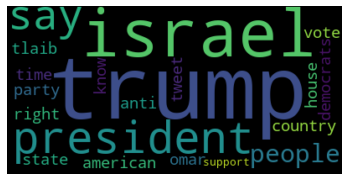

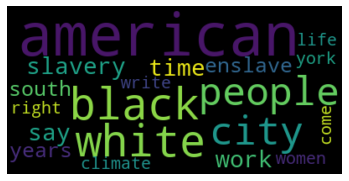

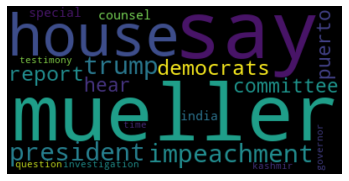

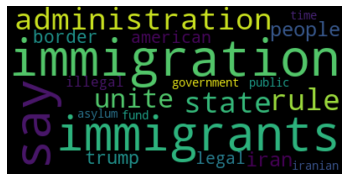

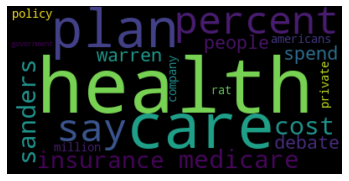

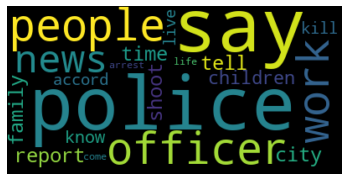

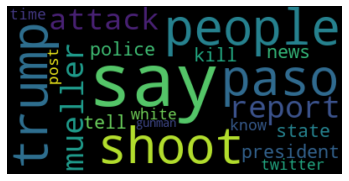

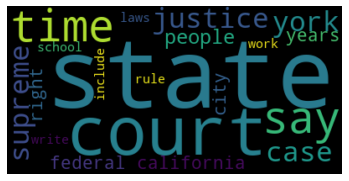

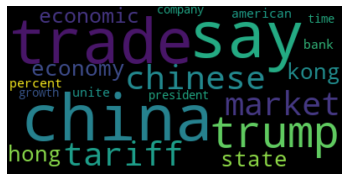

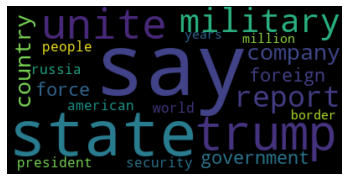

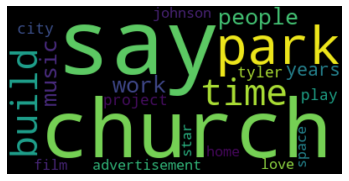

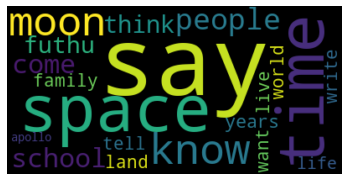

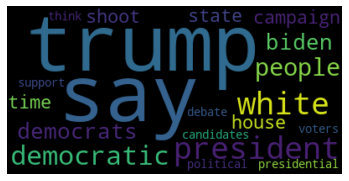

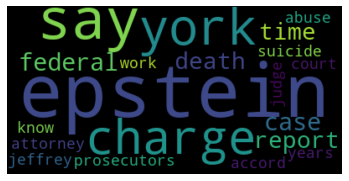

In [280]:
display_topic_wordcloud(lda , count_vectorizer.get_feature_names(), 20)

### Running LDA using TF-IDF

In [281]:
# Tweak the two parameters below
number_topics = 15
number_words = 15


# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(doc_word_tfidf)


# Print the topics found by the LDA model
print("Topics found via LDA:")
#print_topics(lda, count_tfidfvectorizer, number_words)
display_topics(lda, tfidf_vectorizer.get_feature_names(), number_words)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Topics found via LDA:

Topic  0
assign, epstein wealthy, quit, funeral, blind, disparage, loudest, attorneys, smear, rome, wealthy financier, bruise neck, prefer, deposition, circle

Topic  1
say, know, people, president, time, trump, issue, news, report, state, come, tell, support, follow, comment

Topic  2
previously report, leonhardt, david leonhardt, motive, columnist article, receive weekday, head project, columns financial, twitter dleonhardt, leonhardt opinion, subscribe join, subscriber, dleonhardt facebook, newsroom pulitzer, project future

Topic  3
producer, mean think, senator cory, hundreds thousands, speech iowa, notion, verbal, university california, kid black, asian kid, latino coalition, kid asian, coalition moines, notion poor, wealthy kid

Topic  4
sinister, voice nation, racism bigotry, condemn racism, studio, nation condemn, sinister ideologies, bigotry white, islamabad, code, eat, items, prefer, control kashmir, khan say

Topic  5
hauser, news previous, know trump

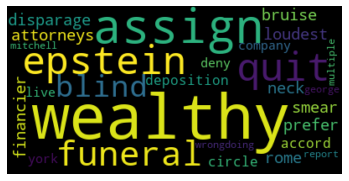

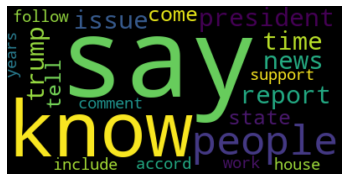

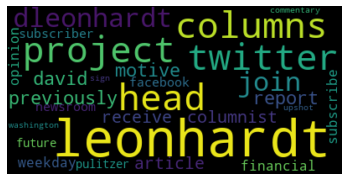

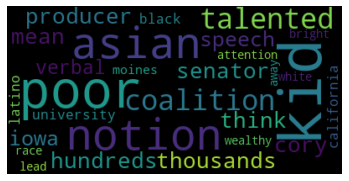

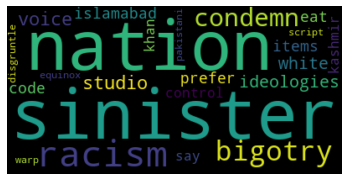

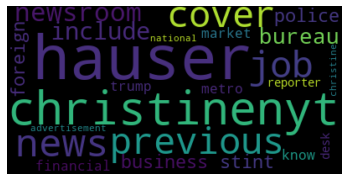

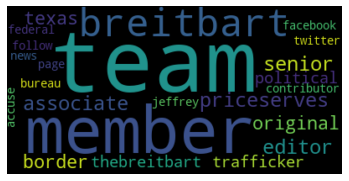

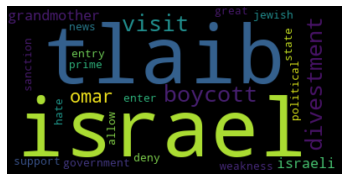

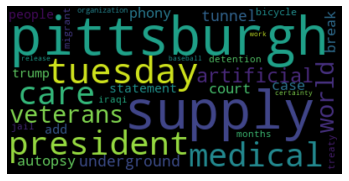

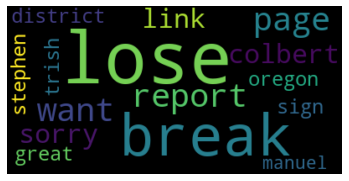

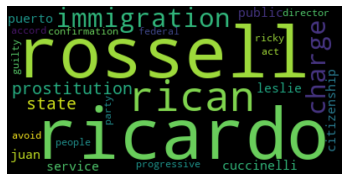

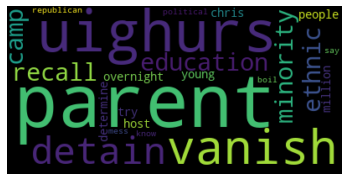

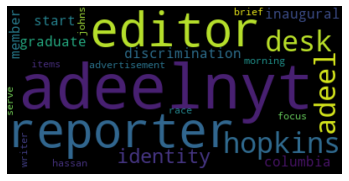

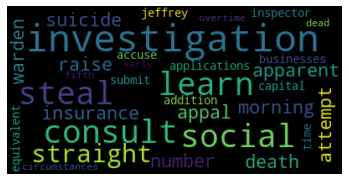

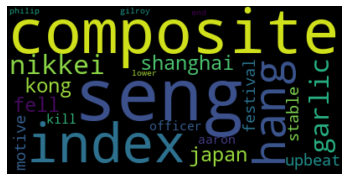

In [283]:
display_topic_wordcloud(lda , tfidf_vectorizer.get_feature_names(), 20)

# Visualize topic modeling with t-SNE

## tSNE for LSA model

In [271]:
# Get topic weights and dominant topics ------------
import random
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


# Dominant topic number in each doc
#topic_num = Vt.idxmax(axis=1)
a = Vt.reset_index()
a = a.drop(['title'], axis=1)
topic_name =  a.idxmax(axis=1)

# Get topic number
topic_num = [int(i.split('_')[1]) for i in topic_name]


# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lsa = tsne_model.fit_transform(Vt)


# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20

color_list =  [color for name, color in mcolors.CSS4_COLORS.items()]
random.shuffle(color_list)
mycolors = np.array(color_list[:10] + [color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=tsne_lsa[:,0], y=tsne_lsa[:,1], color = mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3020 samples in 0.002s...
[t-SNE] Computed neighbors for 3020 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3020
[t-SNE] Computed conditional probabilities for sample 2000 / 3020
[t-SNE] Computed conditional probabilities for sample 3000 / 3020
[t-SNE] Computed conditional probabilities for sample 3020 / 3020
[t-SNE] Mean sigma: 2.368048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.469154
[t-SNE] KL divergence after 1000 iterations: 1.246812


Loading BokehJS ...

## tSNE for NMF model

In [269]:
# Get topic weights and dominant topics ------------
import random
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


# Dominant topic number in each doc
a = H.reset_index()
a = a.drop(['title'], axis=1)
topic_name =  a.idxmax(axis=1)

# Get topic number
topic_num = [int(i.split('_')[1]) for i in topic_name]


# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_nmf = tsne_model.fit_transform(H)


# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20

color_list =  [color for name, color in mcolors.CSS4_COLORS.items()]
random.shuffle(color_list)
mycolors = np.array(color_list[:10] + [color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} NMF Topics".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=tsne_nmf[:,0], y=tsne_nmf[:,1], color = mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3020 samples in 0.004s...
[t-SNE] Computed neighbors for 3020 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3020
[t-SNE] Computed conditional probabilities for sample 2000 / 3020
[t-SNE] Computed conditional probabilities for sample 3000 / 3020
[t-SNE] Computed conditional probabilities for sample 3020 / 3020
[t-SNE] Mean sigma: 0.094423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.113266
[t-SNE] KL divergence after 1000 iterations: 1.022577


Loading BokehJS ...

## tSNE for LDA model

In [311]:
# Get topic weights and dominant topics ------------
import random
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook



'''
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
'''


dataset = [d.split() for d in df['refined_article']]
dictionary = corpora.Dictionary(dataset)
corpus = [dictionary.doc2bow(text) for text in dataset]

lda_model = models.LdaModel.load('./model/ldamodels_tfidf_20.lda')


# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.extend([(i,) + j for j in row_list])


df_topic_weights = pd.DataFrame(topic_weights, columns =['doc', 'topic', 'weight']) 
arr = df_topic_weights.pivot('doc', 'topic', 'weight').fillna(0)    

arr = arr[arr.idxmax(axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = arr.idxmax(axis=1)

# Get topic name
topic_name =['topic_' +  str(i) for i in topic_num]


# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20
#mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])

color_list =  [color for name, color in mcolors.CSS4_COLORS.items()]
random.shuffle(color_list)
mycolors = np.array(color_list[:10] + [color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color = mycolors[topic_num])
show(plot)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3001 samples in 0.002s...
[t-SNE] Computed neighbors for 3001 samples in 0.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3001
[t-SNE] Computed conditional probabilities for sample 2000 / 3001
[t-SNE] Computed conditional probabilities for sample 3000 / 3001
[t-SNE] Computed conditional probabilities for sample 3001 / 3001
[t-SNE] Mean sigma: 0.084217
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.456429
[t-SNE] KL divergence after 1000 iterations: 1.003562


Loading BokehJS ...

# Visualize topic modeling with UMAP 

In [274]:
import umap.umap_ as umap

dataset = [d.split() for d in df['refined_article']]
dictionary = corpora.Dictionary(dataset)
corpus = [dictionary.doc2bow(text) for text in dataset]


# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.extend([(i,) + j for j in row_list])


df_topic_weights = pd.DataFrame(topic_weights, columns =['doc', 'topic', 'weight']) 
arr = df_topic_weights.pivot('doc', 'topic', 'weight').fillna(0) 

# Dominant topic number in each doc
topic_num = arr.idxmax(axis=1)

# Get topic name
topic_name =['topic_' +  str(i) for i in topic_num]



umap_model = umap.UMAP(
    n_neighbors=3,
    n_components=2,
    metric='euclidean'
    )


umap_lda = umap_model.fit_transform(arr)

#plt.scatter(u[:, 0], u[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the compound-target dataset', fontsize=15);

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20
#mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])

color_list =  [color for name, color in mcolors.CSS4_COLORS.items()]
random.shuffle(color_list)
mycolors = np.array(color_list[:10] + [color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="UMAP projection of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=umap_lda[:,0], y=umap_lda[:,1], color = mycolors[topic_num])
show(plot)


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 103 separate connected components using meta-embedding (experimental)



Loading BokehJS ...

In [276]:
fit = umap.UMAP(
        n_neighbors=6,
        n_components=3,
        metric='euclidean'
    )

u = fit.fit_transform(arr)

import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

df = pd.DataFrame(u)
df.columns = ['x', 'y', 'z']

labels = hdbscan.HDBSCAN(
    min_cluster_size=3
).fit(df)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 7 separate connected components using meta-embedding (experimental)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, whic

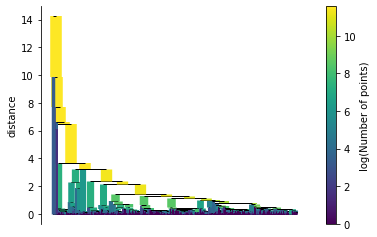

In [277]:
labels.single_linkage_tree_.plot()

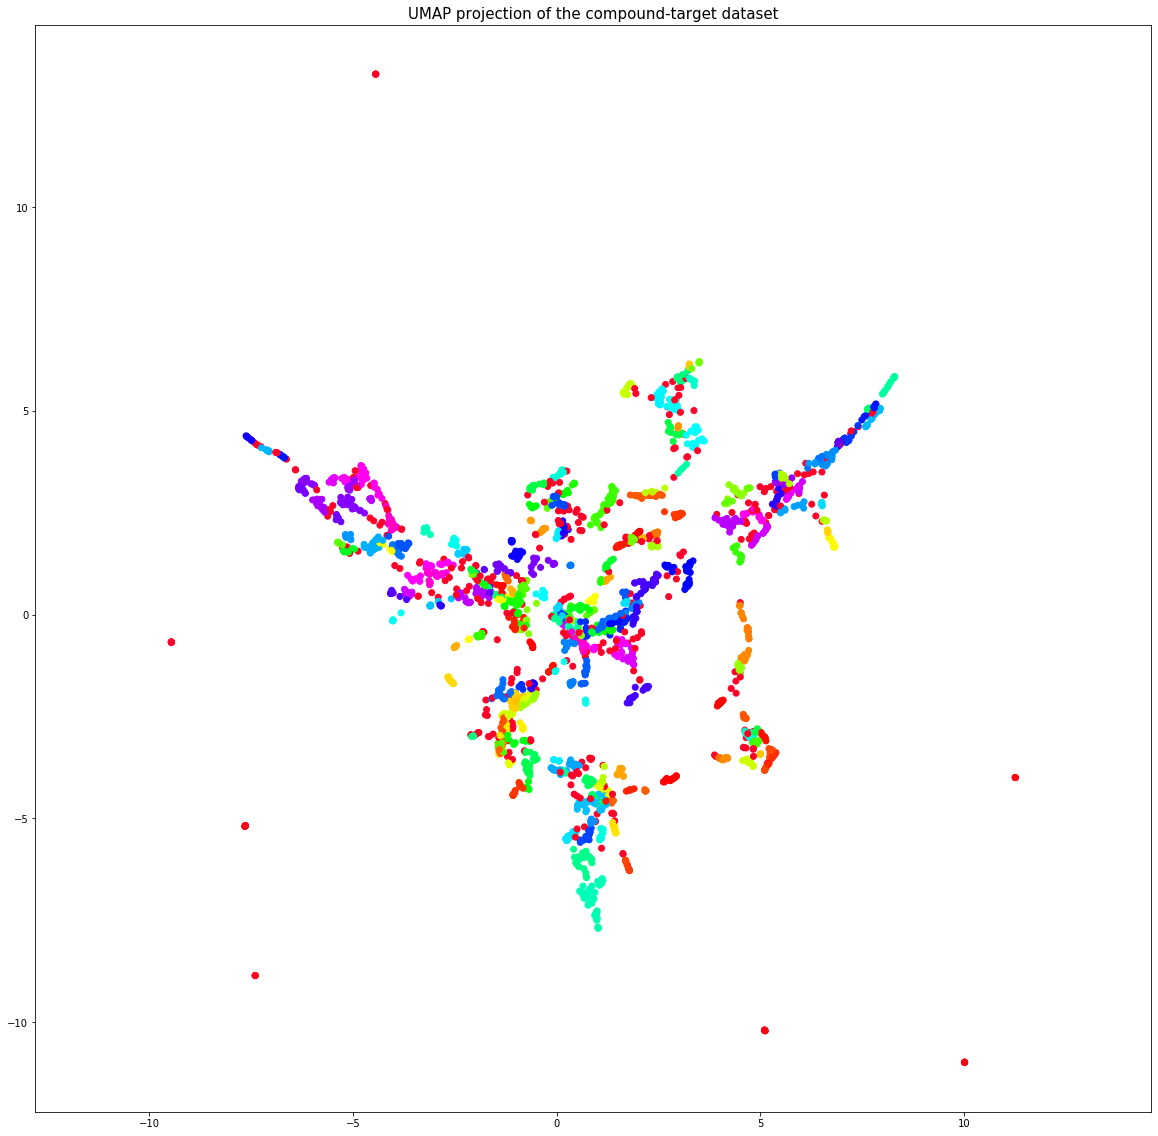

In [278]:
df['labels'] = labels.labels_

plt.figure(figsize=(20,20))
plt.scatter(df.x, df.y, c = df.labels, cmap = 'gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset', fontsize=15);